In [1]:
%matplotlib inline
import numpy as np                  
import matplotlib.pyplot as plt     
import random   
import math
from tqdm import tqdm


from keras.datasets import mnist    
from keras.models import Sequential 

#from keras.layers.core import Dense, Dropout, Activation 
#from keras.utils import np_utils  

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

import matplotlib.image as mpimg
import scipy.ndimage as ndi

from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
import keras

from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from numba import jit
pi = math.pi

import random
#from cv2 import cv2
import cv2
import scipy.stats
import seaborn as sns

from nexusformat.nexus import *
from matplotlib.patches import Circle



# Parameters

In [2]:
a_bulk = 3.905 #SrTiO3 is the bulk
a = a_bulk

c_bulk = 3.905 
c_surf = 3.79 #LaAlO3


Nc = 1000
N_bulk = 8+1
N_surface = 4

#rn describes the bulk atomic xyz positions
r1 = [0, 0, 0]
r2 = [0.5, 0.5, 0.5]
r3 = [0.5, 0.5, 0]
r4 = [0, 0.5, 0.5]
r5 = [0.5, 0, 0.5]

#hard setting the base atom position of the variable bulk and surface
rb1 = [[0, 0, 0]] * N_bulk
s1 = [[0, 0, 0]] * N_surface

#variation of atomic positions
v = 0.05

In [3]:
#creating q mesh
a_SrTiO3 = 3.905
a = a_SrTiO3
dqz = 0.025 * (2*pi/a_SrTiO3)
z_size = 6 * (2*pi/a_SrTiO3)


rod_dimension = 4
dqxy = (2*pi)/a_SrTiO3
xy_size = (rod_dimension-1)*dqxy


x = np.linspace(0, xy_size, rod_dimension)
y = x
z = np.linspace(dqz, z_size, round(z_size/dqz))


[qx, qy, qz] = np.meshgrid(x, y, z)

z_dim = qx.shape[2]
xy_dim = qx.shape[0] * qx.shape[1]


print("XY Dimension: ", qx.shape[0]* qx.shape[1] )
print("Z Dimension: ", qx.shape[2] )
print("Total Points: ", qx.shape[0]* qx.shape[1] *qx.shape[2] )

XY Dimension:  16
Z Dimension:  240
Total Points:  3840


In [4]:
q_mag_squared_term = (qx**2 + qy**2 + qz**2)/((4*pi)**2)
def get_fq(a_arr, b_arr, c_val):
    fq = np.zeros(qx.shape)
    for i in range(4):
        fq += a_arr[i] * np.exp(-b_arr[i] * q_mag_squared_term ) 
    fq += c_val
    return fq

In [5]:
# Define the file path
file_path = 'LSMO_newdat2.XYZ'  # Replace with the actual file path

with open(file_path, 'r') as xyz_file:
    lines = xyz_file.readlines()[2:] # Skipping the first two lines

In [6]:
label = []
x_cobra = []
y_cobra = []
z_cobra = []
DW_factor = []
p_cobra = []

for i in range(len(lines)):
    row = lines[i]
    arr = row.split()
    label.append((arr[0]))
    x_cobra.append(float(arr[1]))
    y_cobra.append(float(arr[2]))
    z_cobra.append(float(arr[3]))
    DW_factor.append(float(arr[4]))
    p_cobra.append(float(arr[5]))
    
    
U_sr = DW_factor[0]
U_la = DW_factor[1]
U_o1 = DW_factor[2]
U_ti = DW_factor[3]
U_mn = DW_factor[4]
U_o3 = DW_factor[5]
U_o2 = DW_factor[6]

In [7]:
#Definining DW Factors
q_squared = (qx**2 + qy**2 + qz**2)


DW_sr = np.exp( (-1/2)*q_squared* U_sr  )
DW_la = np.exp( (-1/2)*q_squared* U_la  )
DW_ti = np.exp( (-1/2)*q_squared* U_ti  )
DW_mn = np.exp( (-1/2)*q_squared* U_mn  )
DW_o1 = np.exp( (-1/2)*q_squared* U_o1  )
DW_o2 = np.exp( (-1/2)*q_squared* U_o2  )
DW_o3 = np.exp( (-1/2)*q_squared* U_o3  )

In [8]:
#change to whatever bulk and surface you're using 
a_Sr = [18.0874, 8.1373, 2.5654, -34.193]
b_Sr = [1.4907, 12.6963, 24.5651, -0.0138]
c_Sr = 41.4025

a_Ti = [19.5114, 8.23473, 2.01341, 1.5208]
b_Ti = [0.178847, 6.67018, -0.29263, 12.9464]
c_Ti = -13.28

a_O = [3.0485, 2.2868, 1.5463, 0.867]
b_O = [13.2771, 5.7011, 0.3239, 32.9089]
c_O = 0.2508

a_La = [20.2489, 19.3763, 11.6323, 0.336048]
b_La = [2.9207, 0.250698, 17.8211, 54.9453]
c_La = 2.4086

a_Al = [4.17448, 3.3876, 1.20296, 0.528137]
b_Al = [1.93816, 4.14553, 0.228753, 8.28524]
c_Al = 0.706786

fq_Sr = get_fq(a_Sr, b_Sr, c_Sr)
fq_Ti = get_fq(a_Ti, b_Ti, c_Ti)
fq_O =  get_fq(a_O, b_O, c_O)
fq_La = get_fq(a_La, b_La, c_La)
fq_Al =  get_fq(a_Al, b_Al, c_Al)

#fq for the bulk and surface
#fq_b = [fq_Sr, fq_Ti, fq_O, fq_O, fq_O]
#fq_s = [fq_La, fq_Al, fq_O, fq_O, fq_O]

fq_b = [fq_Sr*DW_sr, fq_Ti*DW_ti, fq_O*DW_o1, fq_O*DW_o2, fq_O*DW_o3]
fq_s = [fq_La*DW_la, fq_Al*DW_mn, fq_O*DW_o1, fq_O*DW_o2, fq_O*DW_o3]


In [9]:
#an array that is zero at the bragg peaks and one everywhere else
#inverse is the opposite
bragg_peak_arr = np.ones(qx.shape)
bragg_peak_arr_inverse = np.zeros(qx.shape)

for i in range(len(bragg_peak_arr)):
    for j in range(len(bragg_peak_arr[0])):
        for k in range(len(bragg_peak_arr[0][0])):
            if np.allclose(z[k]/(2*pi/a_bulk) % 1,  0):
                bragg_peak_arr[i][j][k] = 0
                bragg_peak_arr_inverse[i][j][k] = 1

# Simulation Methods

In [10]:
#Z scattering
#z_scat_bulk = np.zeros(qx.shape)
#z_scat_bulk = 0.5/np.sin(c_bulk*qz/2)

#simulate general ctr scattering 
def createCTR_allr(r1, r2, r3, r4, r5, rb1, rb2, rb3, rb4, rb5, s1, s2, s3, s4, s5, cn_bulk, cn_surf, mix):
    
   
    z_scat_bulk = np.zeros(qx.shape,dtype=np.complex_)

    nom = 1
    denom = (np.exp(1j * qz * c_bulk)-1)
    z_scat_bulk = (nom/denom)
        
        
    F_q_bulk = np.zeros(qx.shape)

    F_q_bulk = F_q_bulk + fq_b[0]*np.exp( 1j * a_bulk*(qx*r1[0] + qy*r1[1] + qz*r1[2])) #Sr
    F_q_bulk = F_q_bulk + fq_b[1]*np.exp( 1j * a_bulk*(qx*r2[0] + qy*r2[1] + qz*r2[2])) #Ti
    F_q_bulk = F_q_bulk + fq_b[2]*np.exp( 1j * a_bulk*(qx*r3[0] + qy*r3[1] + qz*r3[2])) #O
    F_q_bulk = F_q_bulk + fq_b[3]*np.exp( 1j * a_bulk*(qx*r4[0] + qy*r4[1] + qz*r4[2])) #O
    F_q_bulk = F_q_bulk + fq_b[4]*np.exp( 1j * a_bulk*(qx*r5[0] + qy*r5[1] + qz*r5[2])) #O
    
    bulk = z_scat_bulk*F_q_bulk 
    
    #-------
    
    c_sum = 0
    bulk_variable = np.zeros(qx.shape)
    for i in range(0, N_bulk):
            
        F_q_bulk_var = np.zeros(qx.shape)
        f_mixed = (1-mix[i])*fq_s[0] + mix[i]*fq_b[0]
        F_q_bulk_var = F_q_bulk_var + f_mixed*np.exp( 1j * a_bulk*(qx*rb1[i][0] + qy*rb1[i][1]) + 1j*cn_bulk[i]*(qz*rb1[i][2])) #Sr

        F_q_bulk_var = F_q_bulk_var + fq_b[1]*np.exp( 1j * a_bulk*(qx*rb2[i][0] + qy*rb2[i][1]) +  1j*cn_bulk[i]*(qz*rb2[i][2])) #Ti
        F_q_bulk_var = F_q_bulk_var + fq_b[2]*np.exp( 1j*   a_bulk*(qx*rb3[i][0] + qy*rb3[i][1]) + 1j*cn_bulk[i]*(qz*rb3[i][2])) #O
        F_q_bulk_var = F_q_bulk_var + fq_b[3]*np.exp( 1j *  a_bulk*(qx*rb4[i][0] + qy*rb4[i][1]) + 1j*cn_bulk[i]*(qz*rb4[i][2])) #O
        F_q_bulk_var = F_q_bulk_var + fq_b[4]*np.exp( 1j *  a_bulk*(qx*rb5[i][0] + qy*rb5[i][1]) + 1j*cn_bulk[i]*(qz*rb5[i][2])) #O

        bulk_variable = bulk_variable + F_q_bulk_var*np.exp(1j* qz * c_sum)
        c_sum += cn_bulk[i]
    #-----
    
    
    
    surface = np.zeros(qx.shape)
    for i in range(N_bulk, N_bulk + N_surface):
        
        #if there's mixing
        F_q_surf = np.zeros(qx.shape)
        f_mixed = (1-mix[i])*fq_s[0] + mix[i]*fq_b[0]
        F_q_surf = F_q_surf + f_mixed*np.exp( 1j * a_bulk*(qx*s1[i - N_bulk][0] + qy*s1[i - N_bulk][1]) + 1j*cn_surf[i - N_bulk]*(qz*s1[i - N_bulk][2])) #La
        F_q_surf = F_q_surf + fq_s[1]*np.exp( 1j * a_bulk*(qx*s2[i - N_bulk][0] + qy*s2[i - N_bulk][1]) + 1j*cn_surf[i - N_bulk]*(qz*s2[i - N_bulk][2])) #Al
        F_q_surf = F_q_surf + fq_s[2]*np.exp( 1j*   a_bulk*(qx*s3[i - N_bulk][0] + qy*s3[i - N_bulk][1]) + 1j*cn_surf[i - N_bulk]*(qz*s3[i - N_bulk][2])) #O
        F_q_surf = F_q_surf + fq_s[3]*np.exp( 1j *  a_bulk*(qx*s4[i - N_bulk][0] + qy*s4[i - N_bulk][1]) + 1j*cn_surf[i - N_bulk]*(qz*s4[i - N_bulk][2])) #O
        F_q_surf = F_q_surf + fq_s[4]*np.exp( 1j *  a_bulk*(qx*s5[i - N_bulk][0] + qy*s5[i - N_bulk][1]) + 1j*cn_surf[i - N_bulk]*(qz*s5[i - N_bulk][2])) #O

        surface = surface + F_q_surf*np.exp(1j * qz * c_sum)
        c_sum += cn_surf[i - N_bulk]
    

    e_field = (bulk + bulk_variable + surface)
    ctr = np.abs(bulk + bulk_variable + surface) ** 2
    phase = np.angle(e_field)
        
    
    return ctr, e_field, phase




def createCTR_reshaped_log_allr(r1, r2, r3, r4, r5, rb1, rb2, rb3, rb4, rb5, s1, s2, s3, s4, s5, cn_bulk, cn_surf, mix, beta):
    
   
    
    epsilon = 0.00
    
    ctr, e_field, phase = createCTR_allr(r1, r2, r3, r4, r5, 
                    rb1, rb2, rb3, rb4, rb5, 
                    s1, s2, s3, s4, s5, cn_bulk, cn_surf, mix)
    
    ctr_reshaped = ctr.reshape(xy_dim, z_dim)
    #Roughness parameter
    for rod in range(len(ctr_reshaped)):
        for l in range(len(ctr_reshaped[0])):
            scaling_factor = (1-beta**2)/(1 + beta**2 - 2*beta*np.cos(z[l] * c_surf))
            ctr_reshaped[rod][l] *=  scaling_factor
            
    return np.log(ctr_reshaped + epsilon), e_field, phase


def generatePs():
    generated = False
    betaVal = 0.75
    while (not generated):
        p1 = np.random.beta(betaVal, betaVal)
        p2 = np.random.beta(betaVal, betaVal)
        p3 = np.random.beta(betaVal, betaVal)
        p4 = np.random.beta(betaVal, betaVal)
        tot = (p1 + p2 + p3 + p4)/2
        p1/=tot
        p2/=tot
        p3/=tot
        p4/=tot
        if (p1 > 1 or p2 > 1 or p3 > 1 or p4 > 1):
            continue
        generated = True
        
    return p1, p2, p3, p4

def generateCs(c, n, v):
    c_arr = [c] * n
    for i in range(n):
        c_arr[i] = random.uniform(c-v, c+v)
        
    return c_arr
        
def removeBraggPeaks(CTR, thresh):
    peak_locations = []
    for i in range(len(CTR[0])):
        if CTR[0][i] > thresh:
            peak_locations.append(i)

    return np.delete(CTR, peak_locations, axis = 1)

def generatePositions(positions, v, n):
    defaultPos = np.array([positions] * n)
   
    for i in range(n):
        #2 because we change the z position
        defaultPos[i][2] = random.uniform(positions[2]-v, positions[2]+v)
    return defaultPos

#So the two equatorial oxygens have the same z position
def generateTwoPositions(positions1, positions2, v, n):
    defaultPos1 = np.array([positions1] * n)
    defaultPos2 = np.array([positions2] * n)
   
    for i in range(n):
        #2 because we change the z position
        randZ = random.uniform(positions1[2]-v, positions1[2]+v)
        defaultPos1[i][2] = randZ
        defaultPos2[i][2] = randZ
        
    return defaultPos1, defaultPos2


#MODIFYING THIS METHOD
def getAtomDiffs(cn_bulk, cn_surf, rb, s, zpos, N_bulk, N_surface):
    
    c_B_arr = [0] * N_bulk
    c_S_arr = [0] * N_surface
    
    
    for i in range(len(c_B_arr)):
        if i == 0:
            c_B_arr[i] = c_bulk + cn_bulk[i]*rb[i][2] - c_bulk*zpos
            
        else:
            c_B_arr[i] = cn_bulk[i-1] + cn_bulk[i]*rb[i][2] - cn_bulk[i-1]*rb[i-1][2]
       
    for i in range(len(c_S_arr)):
        if i == 0:
            c_S_arr[i] = cn_bulk[-1] + cn_surf[i]*s[i][2] - cn_bulk[-1]*rb[-1][2]
        else:
            c_S_arr[i] = cn_surf[i-1] + cn_surf[i]*s[i][2] - cn_surf[i-1]*s[i-1][2]
            
    return c_B_arr + c_S_arr
    
def removeBraggPeaks_messy(CTR, bragg_width, thresh):
    #only works if we use a nice number for z!
    peak_locations = []
    totLength = len(CTR[0])
    totRemoved = 0
    for i in range(len(CTR[0])):
        if CTR[0][i] > thresh:
            randArea = np.random.randint(bragg_width)
            
            if i + randArea < totLength:
                peak_locations = np.concatenate([peak_locations, (np.linspace(i-randArea, i + randArea, 2*randArea+1))])
            else:
                peak_locations = np.append(peak_locations, i)
    padding = np.zeros((len(CTR), len(set(peak_locations))))
        
    deleted = np.delete(CTR, peak_locations.astype(int), axis = 1)
    final_padded = np.concatenate([deleted, padding], axis = 1)
    
    return final_padded

#### S(q) method

In [11]:
def get_Sq(r1, r2, r3, r4, r5):
    
    z_scat_bulk = np.zeros(qx.shape,dtype=np.complex_)

    nom = 1
    denom = (np.exp(1j * qz * c_bulk)-1)
    z_scat_bulk = (nom/denom)
        
        
    F_q_bulk = np.zeros(qx.shape)

    F_q_bulk = F_q_bulk + fq_b[0]*np.exp( 1j * a_bulk*(qx*r1[0] + qy*r1[1] + qz*r1[2])) #Sr
    F_q_bulk = F_q_bulk + fq_b[1]*np.exp( 1j * a_bulk*(qx*r2[0] + qy*r2[1] + qz*r2[2])) #Ti
    F_q_bulk = F_q_bulk + fq_b[2]*np.exp( 1j * a_bulk*(qx*r3[0] + qy*r3[1] + qz*r3[2])) #O
    F_q_bulk = F_q_bulk + fq_b[3]*np.exp( 1j * a_bulk*(qx*r4[0] + qy*r4[1] + qz*r4[2])) #O
    F_q_bulk = F_q_bulk + fq_b[4]*np.exp( 1j * a_bulk*(qx*r5[0] + qy*r5[1] + qz*r5[2])) #O
    
    S_q = z_scat_bulk*F_q_bulk 
    
    return S_q

In [12]:
S_q = get_Sq(r1, r2, r3, r4, r5)

In [13]:
np.mean(S_q)

(-8.515494007993489-9648209089619.713j)

# Simulation (loading in data instead)

In [14]:
# Load your numpy arrays
x_train = np.load('x_train_12L_100k.npy')
x_test = np.load('x_test_12L_100k.npy')

y_train_real = np.load('y_train_real_12L_100k.npy')
y_test_real = np.load('y_test_real_12L_100k.npy') 

y_train_imag = np.load('y_train_imag_12L_100k.npy')
y_test_imag = np.load('y_test_imag_12L_100k.npy')

#mean, std arrays for transformation
means_real = np.load("means_real_12L_100k.npy")
std_real = np.load("std_real_12L_100k.npy")

means_imag = np.load("means_imag_12L_100k.npy")
std_imag = np.load("std_imag_12L_100k.npy")

#atomic positions
all_cns = np.load("all_cns_12L_100k.npy")
all_o1s = np.load("all_o1s_12L_100k.npy")
all_o2s = np.load("all_o2s_12L_100k.npy")
all_o3s = np.load("all_o3s_12L_100k.npy")
all_Tis = np.load("all_Tis_12L_100k.npy")
all_ps = np.load("all_ps_12L_100k.npy")


#Split into Train and Validation
train_size = len(x_train)
train_val_split_size = int(0.9 * len(x_train))
x_train_split = x_train[0:train_val_split_size]
y_train_real_split = y_train_real[0:train_val_split_size]
y_train_imag_split =  y_train_imag[0:train_val_split_size]

x_val = x_train[train_val_split_size:]
y_val_real = y_train_real[train_val_split_size:]
y_val_imag =  y_train_imag[train_val_split_size:]


# Create TensorFlow datasets
train_dataset_real = tf.data.Dataset.from_tensor_slices((x_train_split, y_train_real_split))
val_dataset_real = tf.data.Dataset.from_tensor_slices((x_val, y_val_real))

train_dataset_imag = tf.data.Dataset.from_tensor_slices((x_train_split, y_train_imag_split))
val_dataset_imag = tf.data.Dataset.from_tensor_slices((x_val, y_val_imag))

# Define batch size
batch_size = 32

# Satch the training dataset
train_dataset_real = train_dataset_real.batch(batch_size)
train_dataset_imag = train_dataset_imag.batch(batch_size)


# Batch the validation dataset
val_dataset_real = val_dataset_real.batch(batch_size)
val_dataset_imag = val_dataset_imag.batch(batch_size)

2024-07-27 00:21:53.534575: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-07-27 00:21:53.536412: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-27 00:21:53.536416: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-27 00:21:53.536948: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-27 00:21:53.538295: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Building the UNet

In [15]:
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Concatenate


In [16]:
#custom Loss
#see if theres infinite loss type thing
def custom_loss(y_true, y_pred):
    diff = y_true - y_pred
    val = (diff + pi) % (2*pi) - pi
    
    return tf.reduce_mean(tf.abs(val))


In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Concatenate, BatchNormalization

def unet_1d(input_shape):
    inputs = Input(input_shape)

    # Encoding path
    conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv1D(128, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    conv2 = Conv1D(256, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv1D(256, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    # Center path
    conv3 = Conv1D(512, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv1D(512, 3, activation='relu', padding='same')(conv3)

    # Decoding path
    up4 = Conv1D(256, 2, activation='relu', padding='same')(UpSampling1D(size=2)(conv3))
    merge4 = Concatenate(axis=-1)([conv2, up4])
    conv4 = Conv1D(256, 3, activation='relu', padding='same')(merge4)
    conv4 = Conv1D(256, 3, activation='relu', padding='same')(conv4)

    up5 = Conv1D(128, 2, activation='relu', padding='same')(UpSampling1D(size=2)(conv4))
    merge5 = Concatenate(axis=-1)([conv1, up5])
    conv5 = Conv1D(128, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv1D(128, 3, activation='relu', padding='same')(conv5)

    outputs = Conv1D(1, 1, activation='linear', padding='same')(conv5)

    model = Model(inputs, outputs)
    return model

x_new_times_y_new = x_test[0].shape[0]
# Define input shape (476, 1)
input_shape = (x_new_times_y_new, 1)

# Create the modified model
model = unet_1d(input_shape)

# Print the modified model summary
model.summary()
tf.random.set_seed(40)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 3840, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 3840, 128)            512       ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 3840, 128)            49280     ['conv1d[0][0]']              
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 1920, 128)            0         ['conv1d_1[0][0]']            
 D)                                                                                           

# E_real

Epoch 1/30


2024-07-27 00:24:01.313716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2813/2813 [==============================] - ETA: 0s - loss: 0.2836 - mean_absolute_error: 0.2836

2024-07-27 00:50:52.825016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.21091, saving model to unet_12L_100k_30e_real.h5
2813/2813 [==============================] - 1656s 576ms/step - loss: 0.2836 - mean_absolute_error: 0.2836 - val_loss: 0.2109 - val_mean_absolute_error: 0.2109
Epoch 2/30


/Users/pranavkakhandiki/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2813/2813 [==============================] - ETA: 0s - loss: 0.1932 - mean_absolute_error: 0.1932
Epoch 2: val_loss improved from 0.21091 to 0.17990, saving model to unet_12L_100k_30e_real.h5
2813/2813 [==============================] - 1447s 514ms/step - loss: 0.1932 - mean_absolute_error: 0.1932 - val_loss: 0.1799 - val_mean_absolute_error: 0.1799
Epoch 3/30
2813/2813 [==============================] - ETA: 0s - loss: 0.1725 - mean_absolute_error: 0.1725
Epoch 3: val_loss improved from 0.17990 to 0.16491, saving model to unet_12L_100k_30e_real.h5
2813/2813 [==============================] - 1472s 523ms/step - loss: 0.1725 - mean_absolute_error: 0.1725 - val_loss: 0.1649 - val_mean_absolute_error: 0.1649
Epoch 4/30
2813/2813 [==============================] - ETA: 0s - loss: 0.1610 - mean_absolute_error: 0.1610
Epoch 4: val_loss improved from 0.16491 to 0.15410, saving model to unet_12L_100k_30e_real.h5
2813/2813 [==============================] - 1492s 530ms/step - loss: 0.1610 - mea

2813/2813 [==============================] - ETA: 0s - loss: 0.1166 - mean_absolute_error: 0.1166
Epoch 25: val_loss did not improve from 0.12585
2813/2813 [==============================] - 1533s 545ms/step - loss: 0.1166 - mean_absolute_error: 0.1166 - val_loss: 0.1259 - val_mean_absolute_error: 0.1259
Epoch 26/30
2813/2813 [==============================] - ETA: 0s - loss: 0.1162 - mean_absolute_error: 0.1162
Epoch 26: val_loss did not improve from 0.12585
2813/2813 [==============================] - 1544s 549ms/step - loss: 0.1162 - mean_absolute_error: 0.1162 - val_loss: 0.1296 - val_mean_absolute_error: 0.1296
Epoch 27/30
2813/2813 [==============================] - ETA: 0s - loss: 0.1156 - mean_absolute_error: 0.1156
Epoch 27: val_loss did not improve from 0.12585
2813/2813 [==============================] - 1579s 561ms/step - loss: 0.1156 - mean_absolute_error: 0.1156 - val_loss: 0.1275 - val_mean_absolute_error: 0.1275
Epoch 28/30
2813/2813 [==============================] - E

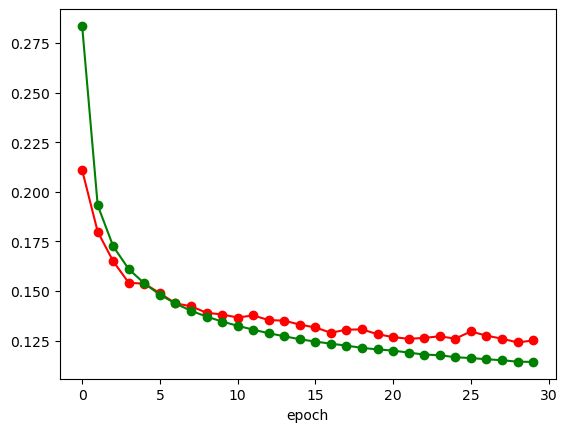

In [18]:
model = unet_1d(input_shape)

with tf.device('/device:CPU:0'):
    model.compile(loss = 'mean_absolute_error',
                 optimizer = "adam",
                 metrics = ['mean_absolute_error'])

checkpointer = tf.keras.callbacks.ModelCheckpoint('unet_12L_100k_30e_real.h5', verbose=1, save_best_only=True)
callbacks = [
    checkpointer
]

# Train your model using the dataset
results = model.fit(train_dataset_real, epochs=30, validation_data=val_dataset_real, callbacks=callbacks)

plt.plot(results.history['val_loss'], 'o-', color = 'red')
plt.plot(results.history['loss'], 'o-', color = 'green')
plt.xlabel('epoch')

np.save("trainLoss_12L_100k_real.npy", results.history['loss'])
np.save("valLoss_12L_100k_real.npy", results.history['val_loss'])

In [19]:
model_new = unet_1d(input_shape)
model_new.load_weights('unet_12L_100k_30e_real.h5')

# Now you can use the model to make predictions

predictions_real = model_new.predict([x_test])
#predictions_train_real = model_new.predict([x_train])

2024-07-27 13:02:40.304110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 6s 150ms/step


# E_imag

Epoch 1/30


2024-07-27 13:02:49.015966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2813/2813 [==============================] - ETA: 0s - loss: 0.2815 - mean_absolute_error: 0.2815

2024-07-27 13:27:53.972516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.21606, saving model to unet_12L_100k_30e_imag.h5
2813/2813 [==============================] - 1547s 537ms/step - loss: 0.2815 - mean_absolute_error: 0.2815 - val_loss: 0.2161 - val_mean_absolute_error: 0.2161
Epoch 2/30
2813/2813 [==============================] - ETA: 0s - loss: 0.1920 - mean_absolute_error: 0.1920
Epoch 2: val_loss improved from 0.21606 to 0.17727, saving model to unet_12L_100k_30e_imag.h5
2813/2813 [==============================] - 1468s 522ms/step - loss: 0.1920 - mean_absolute_error: 0.1920 - val_loss: 0.1773 - val_mean_absolute_error: 0.1773
Epoch 3/30
2813/2813 [==============================] - ETA: 0s - loss: 0.1714 - mean_absolute_error: 0.1714
Epoch 3: val_loss improved from 0.17727 to 0.16706, saving model to unet_12L_100k_30e_imag.h5
2813/2813 [==============================] - 1489s 529ms/step - loss: 0.1714 - mean_absolute_error: 0.1714 - val_loss: 0.1671 - val_mean_absolute_error: 0.1671
Epoch 4/30
2813/2813 [=

2813/2813 [==============================] - 1536s 546ms/step - loss: 0.1175 - mean_absolute_error: 0.1175 - val_loss: 0.1249 - val_mean_absolute_error: 0.1249
Epoch 25/30
2813/2813 [==============================] - ETA: 0s - loss: 0.1167 - mean_absolute_error: 0.1167
Epoch 25: val_loss did not improve from 0.12465
2813/2813 [==============================] - 1553s 552ms/step - loss: 0.1167 - mean_absolute_error: 0.1167 - val_loss: 0.1274 - val_mean_absolute_error: 0.1274
Epoch 26/30
2813/2813 [==============================] - ETA: 0s - loss: 0.1160 - mean_absolute_error: 0.1160
Epoch 26: val_loss did not improve from 0.12465
2813/2813 [==============================] - 1694s 602ms/step - loss: 0.1160 - mean_absolute_error: 0.1160 - val_loss: 0.1247 - val_mean_absolute_error: 0.1247
Epoch 27/30
2813/2813 [==============================] - ETA: 0s - loss: 0.1157 - mean_absolute_error: 0.1157
Epoch 27: val_loss improved from 0.12465 to 0.12361, saving model to unet_12L_100k_30e_imag.h5

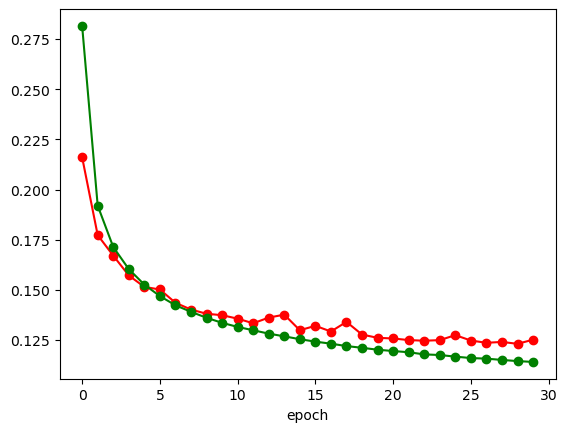

In [20]:
model = unet_1d(input_shape)

with tf.device('/device:CPU:0'):
    model.compile(loss = 'mean_absolute_error',
                 optimizer = "adam",
                 metrics = ['mean_absolute_error'])

checkpointer = tf.keras.callbacks.ModelCheckpoint('unet_12L_100k_30e_imag.h5', verbose=1, save_best_only=True)
callbacks = [
    checkpointer
]

results = model.fit(train_dataset_imag, epochs=30, validation_data=val_dataset_imag, callbacks=callbacks)


plt.plot(results.history['val_loss'], 'o-', color = 'red')
plt.plot(results.history['loss'], 'o-', color = 'green')
plt.xlabel('epoch')

np.save("trainLoss_12L_100k_imag.npy", results.history['loss'])
np.save("valLoss_12L_100k_imag.npy", results.history['val_loss'])

In [21]:
model_new = unet_1d(input_shape)
model_new.load_weights('unet_12L_100k_30e_imag.h5')

predictions_imag = model_new.predict([x_test])
#predictions_train_imag = model_new.predict([x_train])

2024-07-28 01:52:56.877676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 7s 156ms/step


In [22]:
predictions_real = predictions_real.reshape((len(predictions_real), x_new_times_y_new))
y_test_real = y_test_real.reshape((len(y_test_real), x_new_times_y_new))

predictions_imag = predictions_imag.reshape((len(predictions_imag), x_new_times_y_new))
y_test_imag = y_test_imag.reshape((len(y_test_imag), x_new_times_y_new))

In [23]:
predictions_real.shape
len(predictions_real[0])

3840

In [24]:
np.mean(y_test_real)

-0.00017505437894982072

In [25]:
for i in range(3840):
    print(y_test_real[0][i])

-1.6966880834592706
-1.8636035520488328
1.2743548564860963
1.2746049900164875
-1.0049610827245286
-1.0636195883777928
-0.9923692236456185
0.6441389363483898
1.929756296556796
-0.12954399683275097
-2.152051278161588
-0.09348779618480936
2.243854165240971
0.5670691454150592
-1.0494263727579234
-0.37942172694039095
-0.2597622303509172
-0.10527294986161319
1.091518365384201
0.6873459662395169
0.38653700745395075
0.17079932546966453
-0.6121737704332106
-0.9765588275479243
0.10646231126047839
0.7319958970673922
0.15263171047124272
-0.05140094508054511
-0.6481480441843787
-1.3107775751635475
0.5081937786395508
1.764086113048351
-0.6329253641026775
-2.0657906145964096
0.17204500629501557
2.0195211830887256
0.44663130679061497
1.1633651560594633
1.1123749798162876
0.25975315165026963
-1.4827589817996014
-2.209468031618944
0.40718300457286755
0.7385273201552564
-0.5408737693437451
-0.05286436136489127
0.4059831493965625
-0.17922727655795204
0.6568549906894072
0.9739928207725329
-1.04463636081122

In [26]:
mae_pred = 0
mae_rand = 0
for i in range(50):
    mae_pred += np.sum(np.abs(predictions_real[i] - y_test_real[i]))/3840
    mae_rand += np.sum(np.abs(y_test_real[i+1] - y_test_real[i]))/3840
mae_pred /= 50
mae_rand /= 50

In [27]:
mae_pred, mae_rand

(0.1210523660874361, 1.0696293241675796)

In [28]:
mae_pred = 0
mae_rand = 0
for i in range(50):
    mae_pred += np.sum(np.abs(predictions_imag[i] - y_test_imag[i]))/len(predictions_real[i])
    mae_rand += np.sum(np.abs(y_test_imag[i+1] - y_test_imag[i]))/len(predictions_real[i])
    
mae_pred /= 50
mae_rand /= 50

In [29]:
mae_pred, mae_rand

(0.11926577558560476, 1.071454922507429)

Index:  0
R^2:  0.99
Index:  1
R^2:  1.0
Index:  2
R^2:  0.99
Index:  3
R^2:  1.0
Index:  4
R^2:  1.0
Index:  5
R^2:  1.0
Index:  6
R^2:  1.0
Index:  7
R^2:  1.0
Index:  8
R^2:  1.0
Index:  9
R^2:  1.0
Index:  10
R^2:  0.99
Index:  11
R^2:  1.0
Index:  12
R^2:  0.99
Index:  13
R^2:  1.0
Index:  14
R^2:  1.0
Index:  15
R^2:  0.99
Index:  16
R^2:  1.0
Index:  17
R^2:  0.99
Index:  18
R^2:  0.99
Index:  19
R^2:  0.99
Index:  20
R^2:  0.99
Index:  21
R^2:  0.99
Index:  22
R^2:  0.99
Index:  23
R^2:  0.97
Index:  24
R^2:  0.99
Index:  25
R^2:  0.98
Index:  26
R^2:  0.98
Index:  27
R^2:  0.99
Index:  28
R^2:  0.98
Index:  29
R^2:  0.98
Index:  30
R^2:  0.99
Index:  31
R^2:  0.99
Index:  32
R^2:  0.99
Index:  33
R^2:  0.99
Index:  34
R^2:  0.99
Index:  35
R^2:  1.0
Index:  36
R^2:  1.0
Index:  37
R^2:  1.0
Index:  38
R^2:  1.0
Index:  39
R^2:  0.99
Index:  40
R^2:  1.0
Index:  41
R^2:  1.0
Index:  42
R^2:  1.0
Index:  43
R^2:  1.0
Index:  44
R^2:  1.0
Index:  45
R^2:  1.0
Index:  46
R^2:  0.9

R^2:  1.0
Index:  2767
R^2:  0.99
Index:  2768
R^2:  0.99
Index:  2769
R^2:  0.99
Index:  2770
R^2:  0.99
Index:  2771
R^2:  0.98
Index:  2772
R^2:  0.97
Index:  2773
R^2:  0.96
Index:  2774
R^2:  0.92
Index:  2775
R^2:  0.89
Index:  2776
R^2:  0.92
Index:  2777
R^2:  0.89
Index:  2778
R^2:  0.87
Index:  2779
R^2:  0.9
Index:  2780
R^2:  0.84
Index:  2781
R^2:  0.87
Index:  2782
R^2:  0.84
Index:  2783
R^2:  0.8
Index:  2784
R^2:  0.83
Index:  2785
R^2:  0.84
Index:  2786
R^2:  0.74
Index:  2787
R^2:  0.88
Index:  2788
R^2:  0.87
Index:  2789
R^2:  0.91
Index:  2790
R^2:  0.96
Index:  2791
R^2:  0.96
Index:  2792
R^2:  0.97
Index:  2793
R^2:  0.98
Index:  2794
R^2:  0.98
Index:  2795
R^2:  0.98
Index:  2796
R^2:  0.99
Index:  2797
R^2:  0.99
Index:  2798
R^2:  1.0
Index:  2799
R^2:  0.99
Index:  2800
R^2:  1.0
Index:  2801
R^2:  1.0
Index:  2802
R^2:  0.99
Index:  2803
R^2:  0.99
Index:  2804
R^2:  0.99
Index:  2805
R^2:  0.99
Index:  2806
R^2:  0.99
Index:  2807
R^2:  0.99
Index:  280

R^2:  1.0
Index:  3559
R^2:  0.99
Index:  3560
R^2:  1.0
Index:  3561
R^2:  1.0
Index:  3562
R^2:  0.99
Index:  3563
R^2:  0.99
Index:  3564
R^2:  0.99
Index:  3565
R^2:  0.99
Index:  3566
R^2:  0.99
Index:  3567
R^2:  0.99
Index:  3568
R^2:  0.99
Index:  3569
R^2:  0.98
Index:  3570
R^2:  0.98
Index:  3571
R^2:  0.97
Index:  3572
R^2:  0.96
Index:  3573
R^2:  0.96
Index:  3574
R^2:  0.93
Index:  3575
R^2:  0.92
Index:  3576
R^2:  0.87
Index:  3577
R^2:  0.85
Index:  3578
R^2:  0.77
Index:  3579
R^2:  0.81
Index:  3580
R^2:  0.78
Index:  3581
R^2:  0.79
Index:  3582
R^2:  0.79
Index:  3583
R^2:  0.81
Index:  3584
R^2:  0.78
Index:  3585
R^2:  0.83
Index:  3586
R^2:  0.79
Index:  3587
R^2:  0.78
Index:  3588
R^2:  0.81
Index:  3589
R^2:  0.8
Index:  3590
R^2:  0.82
Index:  3591
R^2:  0.85
Index:  3592
R^2:  0.86
Index:  3593
R^2:  0.88
Index:  3594
R^2:  0.93
Index:  3595
R^2:  0.93
Index:  3596
R^2:  0.95
Index:  3597
R^2:  0.98
Index:  3598
R^2:  0.98
Index:  3599
R^2:  0.93
Index:  3

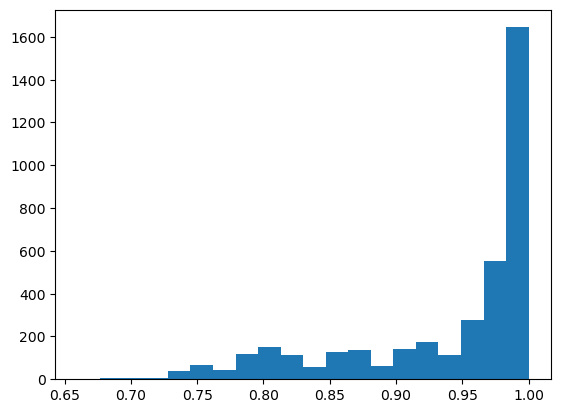

0.938546875


In [30]:
def rSquared(real, preds):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(real, preds)
    return round(r_value**2, 2)

r2_arr = []

for i in range(x_new_times_y_new):
    print("Index: ", i)
    r2_val = rSquared(y_test_real[:, i], predictions_real[:, i])
    print("R^2: ", r2_val)
    r2_arr.append(r2_val)
    #plt.plot(y_train[:, i], predictions_train[:, i] , color = 'blue', linewidth = 5, label = "Train", alpha = 0.2)
    #plt.plot(y_train[:, i], predictions_train[:, i]  ,'.', color = 'blue', linewidth = 0, label = "Train", alpha = 0.2)
    #plt.plot(y_test[:, i], predictions[:, i] , '.', markersize = 10, color = 'orange', label = "Test", alpha = 1)
    #plt.plot(y_test[:, i], y_test[:, i], color = "lightgreen", linewidth = 5, alpha = 0.5)


    #plt.xlabel('Ground Truth', fontname = 'Helvetica',fontsize = 30 )
    #plt.ylabel('Prediction', fontname = 'Helvetica',fontsize = 30  )

    #plt.xticks(fontsize = 17, fontname = 'Helvetica' )
    #plt.yticks(fontsize = 17, fontname = 'Helvetica' )
    #plt.ylim(4, 13)
    #plt.legend(loc='upper left', markerscale=40, prop={'size': 25, "family":'Times new roman'})
    #plt.grid()
    #plt.show()

plt.hist(r2_arr, bins = 20)
plt.show()
print(np.mean(r2_arr))

In [31]:
np.mean(r2_arr)

0.938546875

Index:  0
R^2:  1.0
Index:  1
R^2:  0.99
Index:  2
R^2:  1.0
Index:  3
R^2:  0.99
Index:  4
R^2:  1.0
Index:  5
R^2:  1.0
Index:  6
R^2:  1.0
Index:  7
R^2:  1.0
Index:  8
R^2:  1.0
Index:  9
R^2:  0.99
Index:  10
R^2:  1.0
Index:  11
R^2:  0.99
Index:  12
R^2:  1.0
Index:  13
R^2:  1.0
Index:  14
R^2:  0.99
Index:  15
R^2:  1.0
Index:  16
R^2:  0.99
Index:  17
R^2:  0.99
Index:  18
R^2:  0.99
Index:  19
R^2:  0.99
Index:  20
R^2:  0.99
Index:  21
R^2:  0.99
Index:  22
R^2:  0.97
Index:  23
R^2:  1.0
Index:  24
R^2:  0.98
Index:  25
R^2:  0.99
Index:  26
R^2:  0.99
Index:  27
R^2:  0.98
Index:  28
R^2:  0.99
Index:  29
R^2:  0.99
Index:  30
R^2:  0.98
Index:  31
R^2:  0.99
Index:  32
R^2:  0.99
Index:  33
R^2:  0.99
Index:  34
R^2:  1.0
Index:  35
R^2:  0.99
Index:  36
R^2:  1.0
Index:  37
R^2:  1.0
Index:  38
R^2:  1.0
Index:  39
R^2:  1.0
Index:  40
R^2:  0.99
Index:  41
R^2:  1.0
Index:  42
R^2:  0.99
Index:  43
R^2:  0.99
Index:  44
R^2:  0.97
Index:  45
R^2:  0.99
Index:  46
R^2: 

R^2:  0.75
Index:  1343
R^2:  0.73
Index:  1344
R^2:  0.76
Index:  1345
R^2:  0.74
Index:  1346
R^2:  0.78
Index:  1347
R^2:  0.84
Index:  1348
R^2:  0.88
Index:  1349
R^2:  0.92
Index:  1350
R^2:  0.93
Index:  1351
R^2:  0.95
Index:  1352
R^2:  0.97
Index:  1353
R^2:  0.97
Index:  1354
R^2:  0.98
Index:  1355
R^2:  0.98
Index:  1356
R^2:  0.99
Index:  1357
R^2:  0.99
Index:  1358
R^2:  0.98
Index:  1359
R^2:  1.0
Index:  1360
R^2:  0.99
Index:  1361
R^2:  0.99
Index:  1362
R^2:  1.0
Index:  1363
R^2:  0.99
Index:  1364
R^2:  0.99
Index:  1365
R^2:  0.99
Index:  1366
R^2:  0.98
Index:  1367
R^2:  0.99
Index:  1368
R^2:  0.98
Index:  1369
R^2:  0.98
Index:  1370
R^2:  0.98
Index:  1371
R^2:  0.97
Index:  1372
R^2:  0.97
Index:  1373
R^2:  0.95
Index:  1374
R^2:  0.93
Index:  1375
R^2:  0.9
Index:  1376
R^2:  0.87
Index:  1377
R^2:  0.86
Index:  1378
R^2:  0.82
Index:  1379
R^2:  0.83
Index:  1380
R^2:  0.85
Index:  1381
R^2:  0.85
Index:  1382
R^2:  0.77
Index:  1383
R^2:  0.75
Index:  

R^2:  0.98
Index:  2954
R^2:  0.99
Index:  2955
R^2:  0.99
Index:  2956
R^2:  0.99
Index:  2957
R^2:  1.0
Index:  2958
R^2:  0.98
Index:  2959
R^2:  1.0
Index:  2960
R^2:  0.99
Index:  2961
R^2:  1.0
Index:  2962
R^2:  0.99
Index:  2963
R^2:  1.0
Index:  2964
R^2:  0.99
Index:  2965
R^2:  1.0
Index:  2966
R^2:  0.99
Index:  2967
R^2:  0.99
Index:  2968
R^2:  0.99
Index:  2969
R^2:  0.98
Index:  2970
R^2:  0.98
Index:  2971
R^2:  0.96
Index:  2972
R^2:  0.96
Index:  2973
R^2:  0.92
Index:  2974
R^2:  0.89
Index:  2975
R^2:  0.9
Index:  2976
R^2:  0.89
Index:  2977
R^2:  0.93
Index:  2978
R^2:  0.89
Index:  2979
R^2:  0.87
Index:  2980
R^2:  0.89
Index:  2981
R^2:  0.82
Index:  2982
R^2:  0.81
Index:  2983
R^2:  0.85
Index:  2984
R^2:  0.81
Index:  2985
R^2:  0.83
Index:  2986
R^2:  0.87
Index:  2987
R^2:  0.88
Index:  2988
R^2:  0.93
Index:  2989
R^2:  0.95
Index:  2990
R^2:  0.95
Index:  2991
R^2:  0.98
Index:  2992
R^2:  0.98
Index:  2993
R^2:  0.98
Index:  2994
R^2:  0.99
Index:  299

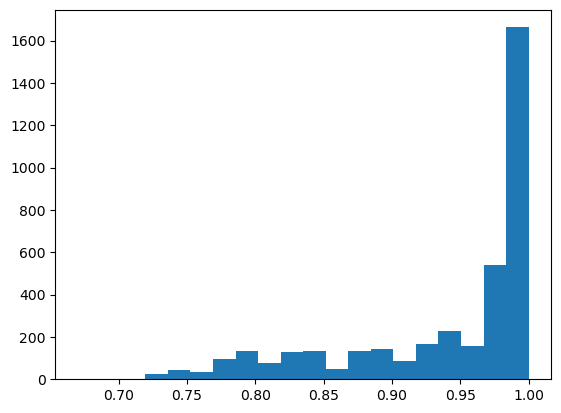

0.9394427083333333


In [32]:
r2_arr = []

for i in range(x_new_times_y_new):
    print("Index: ", i)
    r2_val = rSquared(y_test_imag[:, i], predictions_imag[:, i])
    print("R^2: ", r2_val)
    r2_arr.append(r2_val)
    #plt.plot(y_train[:, i], predictions_train[:, i] , color = 'blue', linewidth = 5, label = "Train", alpha = 0.2)
    #plt.plot(y_train[:, i], predictions_train[:, i]  ,'.', color = 'blue', linewidth = 0, label = "Train", alpha = 0.2)
    #plt.plot(y_test[:, i], predictions[:, i] , '.', markersize = 10, color = 'orange', label = "Test", alpha = 1)
    #plt.plot(y_test[:, i], y_test[:, i], color = "lightgreen", linewidth = 5, alpha = 0.5)


    #plt.xlabel('Ground Truth', fontname = 'Helvetica',fontsize = 30 )
    #plt.ylabel('Prediction', fontname = 'Helvetica',fontsize = 30  )

    #plt.xticks(fontsize = 17, fontname = 'Helvetica' )
    #plt.yticks(fontsize = 17, fontname = 'Helvetica' )
    #plt.ylim(4, 13)
    #plt.legend(loc='upper left', markerscale=40, prop={'size': 25, "family":'Times new roman'})
    #plt.grid()
    #plt.show()

plt.hist(r2_arr, bins = 20)
plt.show()
print(np.mean(r2_arr))

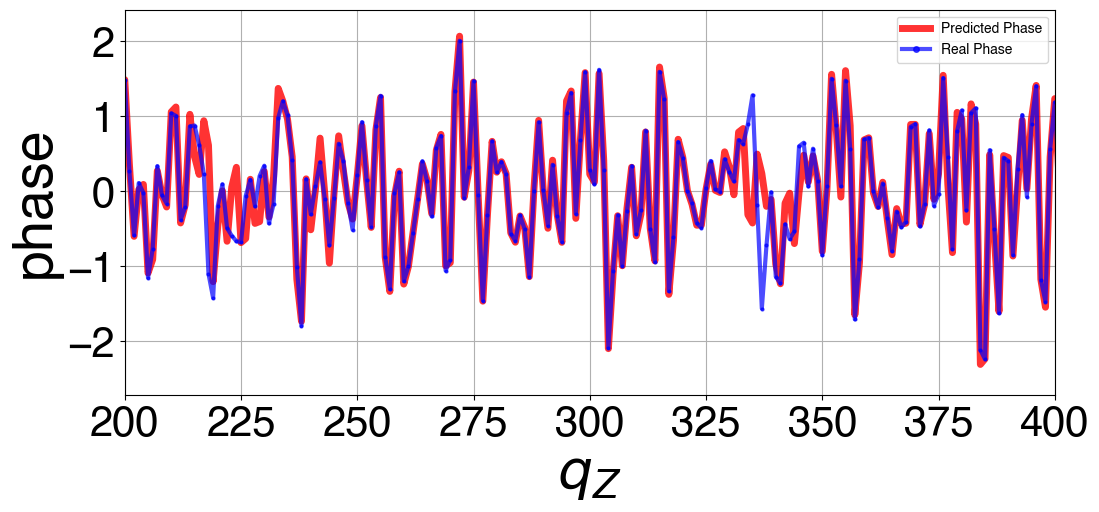

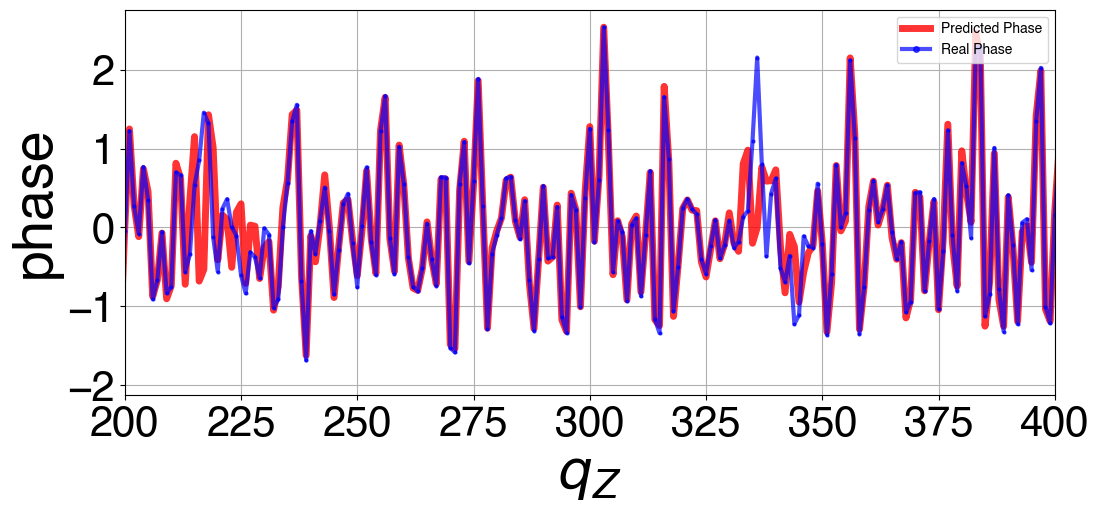

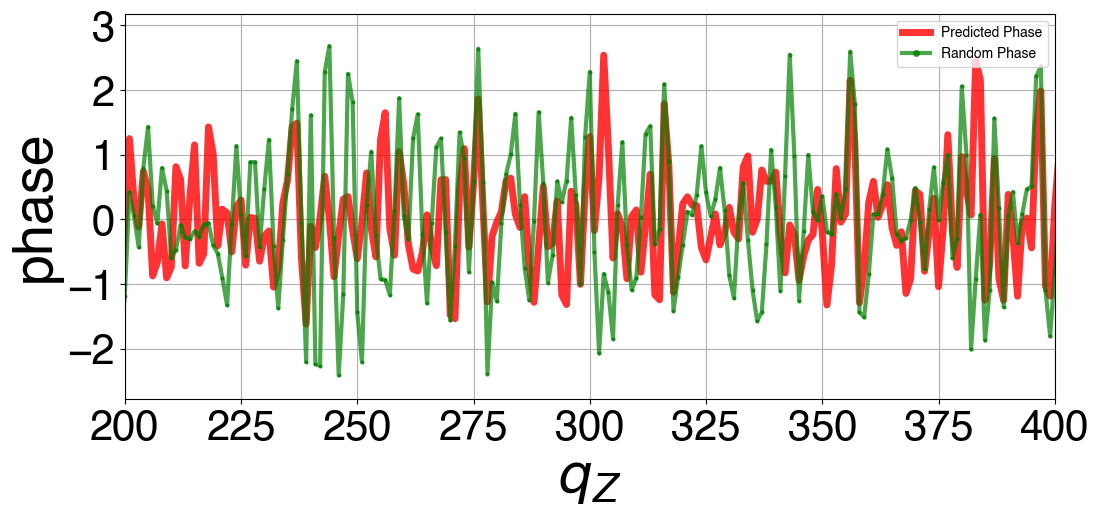

In [33]:
%matplotlib inline
i_rand = np.random.randint(0, 100)
index = 112

plt.figure(figsize=(12, 5))
linwW = 3
markSize = 0
plt.plot(predictions_real[index], color = 'red', label = "Predicted Phase", linewidth = linwW+2, alpha = 0.8, marker = 'o', markersize = markSize)

plt.plot(y_test_real[index], color = 'blue', label = "Real Phase", marker = 'o', markersize = 2, linewidth = 3, alpha = 0.7)

plt.xlabel('$q_{Z}$', fontname = 'Helvetica',fontsize = 40 )
plt.ylabel('phase', fontname = 'Helvetica',fontsize = 40  )
plt.xticks(fontsize = 30, fontname = 'Helvetica' )
plt.yticks(fontsize = 30, fontname = 'Helvetica' )
#plt.ylim(-2, 8)
plt.xlim(200, 400)
plt.legend(loc='upper right', markerscale=2, prop={'size': 10, "family":'Helvetica'})
plt.grid()
plt.show()


                
plt.figure(figsize=(12, 5))
linwW = 3
markSize = 0
plt.plot(predictions_imag[index], color = 'red', label = "Predicted Phase", linewidth = linwW+2, alpha = 0.8, marker = 'o', markersize = markSize)
plt.plot(y_test_imag[index], color = 'blue', label = "Real Phase", marker = 'o', markersize = 2, linewidth = 3, alpha = 0.7)
plt.xlabel('$q_{Z}$', fontname = 'Helvetica',fontsize = 40 )
plt.ylabel('phase', fontname = 'Helvetica',fontsize = 40  )
plt.xticks(fontsize = 30, fontname = 'Helvetica' )
plt.yticks(fontsize = 30, fontname = 'Helvetica' )
#plt.ylim(-2, 8)
plt.xlim(200, 400)
plt.legend(loc='upper right', markerscale=2, prop={'size': 10, "family":'Helvetica'})
plt.grid()
plt.show()


plt.figure(figsize=(12, 5))
linwW = 3
markSize = 0
plt.plot(predictions_imag[index], color = 'red', label = "Predicted Phase", linewidth = linwW+2, alpha = 0.8, marker = 'o', markersize = markSize)
plt.plot(y_test_imag[index+2], color = 'green', label = "Random Phase", marker = 'o', markersize = 2, linewidth = 3, alpha = 0.7)
plt.xlabel('$q_{Z}$', fontname = 'Helvetica',fontsize = 40 )
plt.ylabel('phase', fontname = 'Helvetica',fontsize = 40  )
plt.xticks(fontsize = 30, fontname = 'Helvetica' )
plt.yticks(fontsize = 30, fontname = 'Helvetica' )
#plt.ylim(-2, 8)
plt.xlim(200, 400)
plt.legend(loc='upper right', markerscale=2, prop={'size': 10, "family":'Helvetica'})
plt.grid()
plt.show()



# Getting all U(q) predictions

In [34]:
pred_U_q = []
real_U_q = []
rand_U_q = []

for i in range(len(predictions_real)):
    for j in range(len(predictions_real[0])):        
        predictions_real[i][j] = (predictions_real[i][j]*std_real[j]) + means_real[j]
        predictions_imag[i][j] = (predictions_imag[i][j]*std_imag[j]) + means_imag[j]
        
        y_test_real[i][j] = (y_test_real[i][j]*std_real[j]) + means_real[j]
        y_test_imag[i][j] = (y_test_imag[i][j]*std_imag[j]) + means_imag[j]
        
        
        
pred_U_q = predictions_real + 1j*predictions_imag
real_U_q = y_test_real + 1j*y_test_imag


qx_dim = xy_dim
qz_dim = z_dim
qx_dim = int(np.sqrt(qx_dim))

pred_U_q = np.array(pred_U_q).reshape(len(pred_U_q), qx_dim, qx_dim, qz_dim)
real_U_q = np.array(real_U_q).reshape(len(pred_U_q), qx_dim, qx_dim, qz_dim)


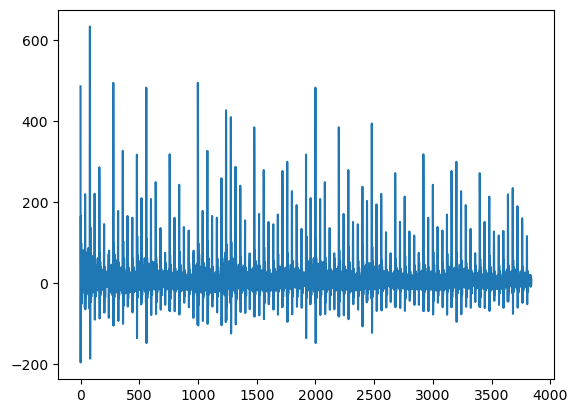

In [35]:
plt.plot(predictions_real[1])

# Plotting Scattering (in house)

In [36]:
#creating q mesh
pi = math.pi

#creating q mesh
dqz = 0.025 * (2*pi/a_bulk)
z_size = 6 * (2*pi/a_bulk)

rod_dimension = 4
dqxy = (2*pi)/a_SrTiO3
xy_size = (rod_dimension-1)*dqxy

#x = np.linspace(0, xy_size, round(xy_size/dqz))
#y = np.linspace(0, xy_size, round(xy_size/dqz))
x = np.linspace(0, xy_size, rod_dimension)
y = x
z = np.linspace(dqz, z_size, round(z_size/dqz))

[qx_pr, qy_pr, qz_pr] = np.meshgrid(x, y, z)

print("Dimension: ", qx_pr.shape[0], qx_pr.shape[1], qx_pr.shape[2] )
print("Total Points: ", qx_pr.shape[0]* qx_pr.shape[1]* qx_pr.shape[2])
print(z/(2*pi/a_bulk))

Dimension:  4 4 240
Total Points:  3840
[0.025 0.05  0.075 ... 5.95  5.975 6.   ]


In [37]:
#dx = 0.4
dx = 0.2
x_size = 15

dy = a_bulk/2
y_size = a_bulk

dz = 0.2
z_start = -10
z_end = 70

z_size = z_end - z_start #we want to see more in the z direction

xr = np.linspace(-x_size/2, x_size/2, int(x_size/dx))-dx
yr = np.linspace(dy, y_size, int(y_size/dy))-dy
#zr = np.linspace(-z_size/2, z_size/2, int(z_size/dz))-dz
zr = np.linspace(z_start, z_end, int(z_size/dz))-dz

[rx, ry, rz] = np.meshgrid(xr, yr, zr)
print("Dimension: ", rx.shape[0], ry.shape[1], rz.shape[2] )
print("Total Points: ", rx.shape[0]* ry.shape[1]* rz.shape[2])

Dimension:  2 75 400
Total Points:  60000


In [38]:
yr

array([0.    , 1.9525])

In [39]:
#below should be vectorized
qx_x_arr = []
qy_y_arr = []
qz_z_arr = []

for i in range(len(xr)):
    qx_x_arr.append(xr[i]*qx_pr)

for i in range(len(yr)):
    qy_y_arr.append(yr[i]*qy_pr)
    
for i in range(len(zr)):
    qz_z_arr.append(zr[i]*qz_pr)

In [40]:
def Eq_to_pr(Eq):
    pr = np.empty(rx.shape,dtype=np.complex_)
    for i in range(len(rx)):
        for j in range(len(rx[0])):
            for k in range(len(rx[0][0])):
              
                #make these beforehand
                Mr = np.exp(-1j * (qx_x_arr[j] + qy_y_arr[i] + qz_z_arr[k]))
                pr[i][j][k] = np.sum(Eq * Mr)
    return pr

# Gaussian Window

In [41]:
def create_3d_symmetric_gaussian(std_dev, array_size):
    #if len(array_size) != 3 or array_size[0] != array_size[1] or array_size[1] != array_size[2]:
        #raise ValueError("Array size should be a tuple with three equal dimensions.")

    x, y, z = np.meshgrid(
        np.linspace(-1, 1, array_size[0]),
        np.linspace(-1, 1, array_size[1]),
        np.linspace(-1, 1, array_size[2])
    )

    r_squared = x**2 + y**2 + z**2
    gaussian = np.exp(-0.5 * (r_squared / std_dev**2))
    
    max_value = 1.0
    gaussian /= gaussian.max()  # Normalize to have max value of 1
    
    return gaussian

array_size = real_U_q[0].shape

In [42]:
def create_3d_symmetric_gaussian_diff_z(std_dev_xy, std_dev_z, array_size):
    x, y, z = np.meshgrid(
        np.linspace(-1, 1, array_size[0]),
        np.linspace(-1, 1, array_size[1]),
        np.linspace(-1, 1, array_size[2])
    )

    r_squared_xy = x**2 + y**2
    r_squared_z = z**2
    gaussian_xy = np.exp(-0.5 * (r_squared_xy / std_dev_xy**2))
    gaussian_z = np.exp(-0.5 * (r_squared_z / std_dev_z**2))
    
    gaussian = gaussian_xy * gaussian_z

    max_value = 1.0
    gaussian /= gaussian.max()  # Normalize to have max value of 1
    
    return gaussian


# STD = 0.75

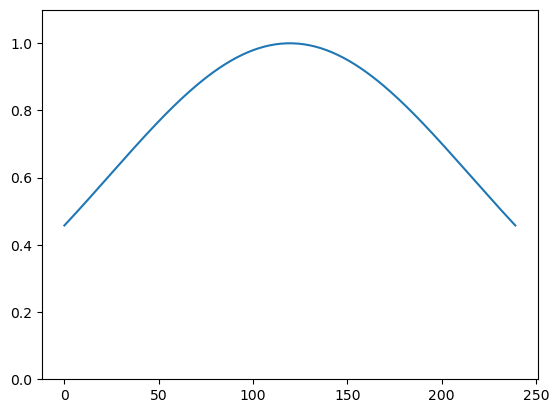

In [43]:
std_dev = 0.75  # Adjust this value to control the spread of the Gaussian
gaussian_window_filter = create_3d_symmetric_gaussian_diff_z(0.7, 0.8, array_size)
plt.plot(gaussian_window_filter[1][1])
plt.ylim(0, 1.1)
plt.show()

In [44]:
create_3d_symmetric_gaussian(0.7, array_size).shape

(4, 4, 240)

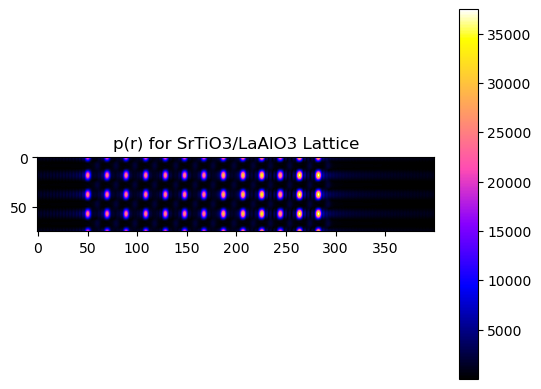

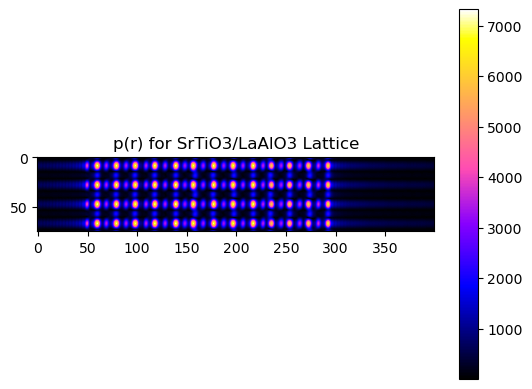

In [45]:
index = 10

pr_test = Eq_to_pr(gaussian_window_filter*real_U_q[index])


plt.imshow((np.abs(pr_test[0])), cmap = 'gnuplot2')
plt.title("p(r) for SrTiO3/LaAlO3 Lattice")
plt.colorbar()
#plt.clim(0, 5000)
plt.show()

plt.imshow((np.abs(pr_test[1])), cmap = 'gnuplot2')
plt.title("p(r) for SrTiO3/LaAlO3 Lattice")
plt.colorbar()
#plt.clim(0, 5000)


# Atomic Position Extraction

In [46]:
def gaussian(x, amplitude, mean, std_dev):
    return amplitude * np.exp(-(x - mean) ** 2 / (2 * std_dev ** 2))

# Applying ifft and obtaining predictions

In [47]:
qx_pr.shape

(4, 4, 240)

In [48]:
#goal = method that returns p(r) once given the 4x4x240 U(q)

#1. internal zero padding
dqz = 0.025 * (2*pi/a_bulk)

dqx = 0.2 * (2*pi/a_bulk)

z_size = 6 * (2*pi/a_bulk)

rod_dimension = 4
dqxy = (2*pi)/a_SrTiO3
xy_size = (rod_dimension-1)*(2*pi/a_bulk)

x = np.linspace(0, xy_size, round(xy_size/dqx)+1)
y = np.linspace(0, xy_size, round(xy_size/dqx)+1)
z = np.linspace(dqz, z_size, round(z_size/dqz))

[qx_pr, qy_pr, qz_pr] = np.meshgrid(x, y, z)


def internal_zero_pad(U_q):

    E_q_real_FULL = np.zeros(qx_pr.shape,dtype=np.complex_ )

    for i in range(len(E_q_real_FULL)):
        for j in range(len(E_q_real_FULL[0])):
            if ((np.isclose((x[i]/((2*pi/a_bulk))) % 1,0.0) or np.isclose((x[i]/((2*pi/a_bulk))) % 1,1.0))
                and (np.isclose((y[j]/((2*pi/a_bulk))) % 1,0.0) or np.isclose((y[j]/((2*pi/a_bulk))) % 1,1.0))):
                
                divisor = (1/dqx)* (2*pi/a_bulk)
                #print(divisor)
                rod_x = int((i+1)/divisor)
                rod_y = int((j+1)/divisor) 
                
                #rod_x = int((i+1)/40)
                #rod_y = int((j+1)/40) 

                E_q_real_FULL[i][j] = U_q[rod_x][rod_y]
                
    return E_q_real_FULL


#2. xyz symmetries
def perovskite_sym_xyz(internally_padded_U_q):
    nx, ny, nz = internally_padded_U_q.shape
    shift_xy = int((2*nx - 1)/2)
    shift_z = int((2*nz + 1)/2)
    divisor = (1/dqx)* (2*pi/a_bulk)
    symmetric_real_U_q = np.zeros(((2*nx - 1,2*ny - 1, 2*nz+1)),dtype=np.complex_)

    for xi in range(len(symmetric_real_U_q)):
        for yi in range(len(symmetric_real_U_q[0])):
            for zi in range(len(symmetric_real_U_q[0][0])):

                #fixing the qx = 0 issue 
                if xi % divisor == 0 and yi %divisor == 0 and zi-shift_z == 0:
                    symmetric_real_U_q[xi][yi][zi] = 600

                elif zi-shift_z > 0:
                    symmetric_real_U_q[xi][yi][zi] = internally_padded_U_q[abs(xi-shift_xy)][abs(yi-shift_xy)][abs(zi-shift_z)-1]
                else:
                    symmetric_real_U_q[xi][yi][zi] = np.conjugate(internally_padded_U_q[abs(xi-shift_xy)][abs(yi-shift_xy)][abs(zi-shift_z)-1])
    
    return symmetric_real_U_q

#Externally zero padding

def pad_3d_array(array, pad_x, pad_y, pad_z):
  
    padded_array = np.pad(array, ((pad_x, pad_x), (pad_y, pad_y), (pad_z, pad_z)), mode='constant')
    return padded_array

def pad_3d_array_uneven(array, pad_x, pad_y, pad_z):
  
    padded_array = np.pad(array, ((pad_x, pad_x+1), (pad_y, pad_y+1), (pad_z, pad_z+1)), mode='constant')
    return padded_array

def np_ifft_full_process(U_q):
    #padx = 135
    #pady = 135
    #padz = 271

    padx = 60
    pady = 60
    padz = 1000
    std_dev = 0.1  # Adjust this value to control the spread of the Gaussian
    std_dev_xy = 0.1
    std_dev_z = 0.05
    E_q_real_FULL = internal_zero_pad(U_q)
    symmetric_real_U_q = perovskite_sym_xyz(E_q_real_FULL)
    #padded_real_U_q = pad_3d_array_uneven(symmetric_real_U_q, padx, pady, padz)
    padded_real_U_q = pad_3d_array(symmetric_real_U_q, padx, pady, padz)
    
    array_size = padded_real_U_q.shape

    #gaussian_window_filter = create_3d_symmetric_gaussian(std_dev, array_size)
    gaussian_window_filter = create_3d_symmetric_gaussian_diff_z(std_dev_xy, std_dev_z, array_size)
    raw_ifft = np.fft.ifftn((padded_real_U_q*gaussian_window_filter))
    return raw_ifft
    

In [49]:
print((512 - 241-1)/2)
print((1024-481-1)/2)

135.0
271.0


In [50]:
z_size

9.654061931645971

In [51]:
pr_test = np_ifft_full_process(real_U_q[0])
pr_test.shape

(151, 151, 2481)

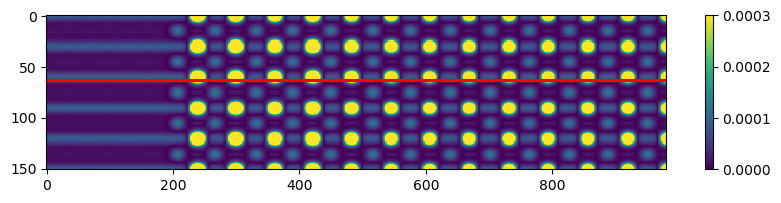

In [52]:
pr_abs = np.abs(pr_test)
plt.figure(figsize=(10, 2))
plt.imshow(pr_abs[0][:, 1500:], interpolation='nearest', aspect='auto')
plt.axhline(63, color = 'red')
plt.axhline(64, color = 'red')

plt.colorbar()
plt.clim(0, 0.0003)
#plt.xlim(0, 424)
#plt.ylim(0,424)
plt.show()


In [53]:
pr_test.shape
from pylab import *
#sys.getsizeof(pr_abs[14][:, 1500:])
pr_abs[14][:, 1500:].nbytes/1e9


0.001185048

In [54]:
"""
Config That works:

padx = 60
pady = 60
padz = 1000
std_dev_xy = 0.1
std_dev_z = 0.05
0 and 14 are good slices

"""

'\nConfig That works:\n\npadx = 60\npady = 60\npadz = 1000\nstd_dev_xy = 0.1\nstd_dev_z = 0.05\n0 and 14 are good slices\n\n'

# Extracting Positions

In [55]:
N_z = pr_test.shape[2]
delta_r = (2*pi*(1/dqz) )/N_z
print("Angstroms per pixel: ", delta_r)

Angstroms per pixel:  0.06295848448206368


In [56]:
def fit_p_r_new(pr_slice, start, a_space):

    gaussian_fits_y = np.zeros(20*len(pr_slice))
    gaussian_fits_x = np.linspace(0, len(pr_slice)-1,  20*len(pr_slice))
    points_around_max = 5
    
    #pixel_ratio = 0.1525390625
    pixel_ratio = 0.06293311845286059
    #pixel_ratio = 0.03485829056014282
    atomic_spacings = []
    N = len(pr_slice)
    means = []
    right = []
    left = []
    for atom in range(N_bulk+N_surface):
        i = start + atom*a_space
        interval = pr_slice[i:i+a_space]
        max_ind = np.argmax(interval)
        
        
        #atomic_section = interval[max_ind - points_around_max: max_ind + points_around_max+1]
        
        atomic_section = pr_slice[i+max_ind - points_around_max:i+max_ind + points_around_max+1]
        
        
        #fitting gaussian
        num_points = len(atomic_section)
        x_d = np.arange(num_points)        
        #print("Interval: ", interval)
        #print("Max ind: ", max_ind)
        params, covariance = curve_fit(gaussian, x_d, atomic_section, p0=[1, 3, 3])
        
        
        amplitude, mean, std_dev = params
        
        
        means.append(mean)
        right.append(a_space - (max_ind + points_around_max))
        left.append(max_ind - points_around_max)
        
        gaussian_fits_y += gaussian(gaussian_fits_x, amplitude, mean+left[atom]+i, std_dev)
        
        #print(amplitude, mean+left[atom]+i, std_dev)
       
        
    for i in range(N_bulk+N_surface-1):
        index_space = right[i] + left[i+1] + (2*points_around_max - means[i]) + means[i+1]
        atomic_spacings.append(pixel_ratio * index_space)
        
        
    return atomic_spacings, gaussian_fits_y


In [ ]:
pr_real = []
for i in tqdm(range(50)):
    pr_temp = np.abs(np_ifft_full_process(real_U_q[i]))
    pr_real.append([ pr_temp[0][:, 1500:], pr_temp[14][:, 1500:]])
    #pr_real.append([ pr_temp[13][0:100, 1600:], pr_temp[19][0:100, 1600:]])
    del pr_temp

 10%|██████▌                                                           | 5/50 [00:35<05:15,  7.02s/it]

In [ ]:
pr_real = np.array(pr_real)

In [ ]:
pr_pred = []
for i in tqdm(range(50)):
    pr_temp = np.abs(np_ifft_full_process(pred_U_q[i]))
    pr_pred.append([ pr_temp[0][:, 1500:], pr_temp[14][:, 1500:]])
    #pr_real.append([ pr_temp[13][0:100, 1600:], pr_temp[19][0:100, 1600:]])
    del pr_temp

In [ ]:
pr_pred = np.array(pr_pred)

# Sr

In [ ]:
index = 0

In [ ]:
plt.figure(figsize=(10, 2))
plt.imshow(pr_pred[0][0], interpolation='nearest', aspect='auto')
plt.axhline(55, color = 'red')
plt.axhline(64, color = 'red')

plt.colorbar()
plt.clim(0, 0.0003)
#plt.xlim(0, 424)
#plt.ylim(0,424)
plt.show()


In [ ]:
for j in range(50):

    plt.figure(figsize=(12, 4))
    pr_slice_Sr = np.sum(pr_pred[j][0][55:64], axis = 0)
    #pr_slice_Sr = np.sum(pr_real[index][0][59:62], axis = 0)
    plt.plot(pr_slice_Sr, '.-')


    start = 270 - 62
    spacing = 62
    #start = 172
    #spacing = 62
    for i in range(N_bulk+N_surface): 
        plt.axvline(start + i*spacing, color = "red")

    plt.show()

In [ ]:
start = 270 - 62
a_space = 62
real_cns = []
pred_cns = []

for i in range(len(pr_real)):
    pr_slice_Sr = np.sum(pr_real[i][0][55:64], axis = 0)
    spacings, gaus_fit = fit_p_r_new(pr_slice_Sr, start, a_space)
    spacings = np.flip(spacings)
    real_cns.append(spacings)

for i in range(len(pr_pred)):
    print(i)
    pr_slice_Sr = np.sum(pr_pred[i][0][55:64], axis = 0)
    spacings, gaus_fit = fit_p_r_new(pr_slice_Sr, start, a_space)
    spacings = np.flip(spacings)
    pred_cns.append(spacings)
    
real_cns = np.array(real_cns)
pred_cns = np.array(pred_cns)

In [ ]:
input_cns = np.array(all_cns[train_size:train_size+50])
r2_arr_pr = []

for i in range(N_bulk+N_surface-1):
    #First layer spacing doesn't change since dummy layer
    if i == 0:
        continue
    print("Index: ", i)
    r2_val = rSquared(real_cns[:, i], input_cns[:, i])
    print("R^2: ", r2_val)
    r2_arr_pr.append(r2_val)
    #plt.plot(y_train[:, i], predictions_train[:, i] , color = 'blue', linewidth = 5, label = "Train", alpha = 0.2)
    #plt.plot(y_train[:, i], predictions_train[:, i]  ,'.', color = 'blue', linewidth = 0, label = "Train", alpha = 0.2)
    
    fig = plt.figure(figsize = (3, 3))
    plt.rcParams['axes.linewidth'] = 2
    plt.plot(real_cns[:, i], real_cns[:, i], color = "lightgreen", linewidth = 3, alpha = 0.5)

    plt.plot(real_cns[:, i], input_cns[:, i] , '.', markersize = 10, color = 'purple', label = "Test", alpha = 1)


    plt.xlabel('Ground Truth(Å)', fontname = 'Helvetica',fontsize = 15 )
    plt.ylabel('Prediction(Å)', fontname = 'Helvetica',fontsize = 15  )

    plt.xticks(fontsize = 13, fontname = 'Helvetica' )
    plt.yticks(fontsize = 13, fontname = 'Helvetica' )
    #plt.ylim(4, 13)
    #plt.legend(loc='upper left', markerscale=2, prop={'size': 25, "family":'Times new roman'})
    #plt.grid()
    plt.show()

plt.hist(r2_arr_pr, bins = 20)
plt.show()
    

In [ ]:
r2_arr_pr_cn = []

for i in range(N_bulk+N_surface-1):
    #First layer spacing doesn't change since dummy layer
    if i == 0:
        continue
    print("Index: ", i)
    r2_val = rSquared(real_cns[:, i], pred_cns[:, i])
    print("R^2: ", r2_val)
    r2_arr_pr_cn.append(r2_val)
    #plt.plot(y_train[:, i], predictions_train[:, i] , color = 'blue', linewidth = 5, label = "Train", alpha = 0.2)
    #plt.plot(y_train[:, i], predictions_train[:, i]  ,'.', color = 'blue', linewidth = 0, label = "Train", alpha = 0.2)
    
    fig = plt.figure(figsize = (3, 3))
    plt.rcParams['axes.linewidth'] = 2
    plt.plot(real_cns[:, i], real_cns[:, i], color = "lightgreen", linewidth = 3, alpha = 0.5)

    plt.plot(real_cns[:, i], pred_cns[:, i] , '.', markersize = 10, color = 'purple', label = "Test", alpha = 1)


    plt.xlabel('Ground Truth(Å)', fontname = 'Helvetica',fontsize = 15 )
    plt.ylabel('Prediction(Å)', fontname = 'Helvetica',fontsize = 15  )

    plt.xticks(fontsize = 13, fontname = 'Helvetica' )
    plt.yticks(fontsize = 13, fontname = 'Helvetica' )
    #plt.ylim(4, 13)
    #plt.legend(loc='upper left', markerscale=2, prop={'size': 25, "family":'Times new roman'})
    #plt.grid()
    plt.show()

plt.hist(r2_arr_pr_cn, bins = 20)
plt.show()
print(np.mean(r2_arr_pr_cn))

# O1

In [ ]:
plt.figure(figsize=(10, 2))
plt.imshow(pr_pred[0][0], interpolation='nearest', aspect='auto')
plt.axhline(73, color = 'red')
plt.axhline(77, color = 'red')

plt.colorbar()
plt.clim(0, 0.0002)
#plt.xlim(0, 424)
#plt.ylim(0,424)
plt.show()


In [ ]:
for j in range(50):

    plt.figure(figsize=(12, 4))
    pr_slice_O1 = np.sum(pr_pred[j][0][73:77], axis = 0)
    #pr_slice_O1 = np.sum(pr_real[index][0][63:64], axis = 0)
    plt.plot(pr_slice_O1, '.-')


    start = 245-62
    spacing = 62
    #start = 145
    #spacing = 62
    for i in range(N_bulk+N_surface): 
        plt.axvline(start + i*spacing, color = "red")

    plt.show()

In [ ]:
start = 245 - 62
a_space = 62
real_o1s = []
pred_o1s = []

for i in range(len(pr_real)):
    pr_slice_o1 = np.sum(pr_real[i][0][73:77], axis = 0)
    spacings, gaus_fit = fit_p_r_new(pr_slice_o1, start, a_space)
    spacings = np.flip(spacings)
    real_o1s.append(spacings)

for i in range(len(pr_pred)):
    print(i)
    pr_slice_o1 = np.sum(pr_pred[i][0][73:77], axis = 0)
    spacings, gaus_fit = fit_p_r_new(pr_slice_o1, start, a_space)
    spacings = np.flip(spacings)
    pred_o1s.append(spacings)
    
real_o1s = np.array(real_o1s)
pred_o1s = np.array(pred_o1s)


In [ ]:
real_o1s.shape

In [ ]:
input_o1s = np.array(all_o1s[train_size:train_size+50])
r2_arr_pr = []

for i in range(N_bulk+N_surface-1):

    print("Index: ", i)
    r2_val = rSquared(real_o1s[:, i], input_o1s[:, i+1])
    print("R^2: ", r2_val)
    r2_arr_pr.append(r2_val)
    #plt.plot(y_train[:, i], predictions_train[:, i] , color = 'blue', linewidth = 5, label = "Train", alpha = 0.2)
    #plt.plot(y_train[:, i], predictions_train[:, i]  ,'.', color = 'blue', linewidth = 0, label = "Train", alpha = 0.2)
    
    fig = plt.figure(figsize = (3, 3))
    plt.rcParams['axes.linewidth'] = 2
    plt.plot(real_o1s[:, i], real_o1s[:, i], color = "lightgreen", linewidth = 3, alpha = 0.5)

    plt.plot(real_o1s[:, i], input_o1s[:, i+1] , '.', markersize = 10, color = 'purple', label = "Test", alpha = 1)


    plt.xlabel('Ground Truth(Å)', fontname = 'Helvetica',fontsize = 15 )
    plt.ylabel('Prediction(Å)', fontname = 'Helvetica',fontsize = 15  )

    plt.xticks(fontsize = 13, fontname = 'Helvetica' )
    plt.yticks(fontsize = 13, fontname = 'Helvetica' )
    #plt.ylim(4, 13)
    #plt.legend(loc='upper left', markerscale=2, prop={'size': 25, "family":'Times new roman'})
    #plt.grid()
    plt.show()

plt.hist(r2_arr_pr, bins = 20)
plt.show()
print(np.mean(r2_arr_pr))

In [ ]:
r2_arr_pr_o1 = []

for i in range(N_bulk+N_surface-1):

    print("Index: ", i)
    r2_val = rSquared(pred_o1s[:, i], real_o1s[:, i])
    print("R^2: ", r2_val)
    r2_arr_pr_o1.append(r2_val)
    #plt.plot(y_train[:, i], predictions_train[:, i] , color = 'blue', linewidth = 5, label = "Train", alpha = 0.2)
    #plt.plot(y_train[:, i], predictions_train[:, i]  ,'.', color = 'blue', linewidth = 0, label = "Train", alpha = 0.2)
    
    fig = plt.figure(figsize = (3, 3))
    plt.rcParams['axes.linewidth'] = 2
    plt.plot(pred_o1s[:, i], pred_o1s[:, i], color = "lightgreen", linewidth = 3, alpha = 0.5)

    plt.plot(pred_o1s[:, i], real_o1s[:, i] , '.', markersize = 10, color = 'purple', label = "Test", alpha = 1)


    plt.xlabel('Ground Truth(Å)', fontname = 'Helvetica',fontsize = 15 )
    plt.ylabel('Prediction(Å)', fontname = 'Helvetica',fontsize = 15  )

    plt.xticks(fontsize = 13, fontname = 'Helvetica' )
    plt.yticks(fontsize = 13, fontname = 'Helvetica' )
    #plt.ylim(4, 13)
    #plt.legend(loc='upper left', markerscale=2, prop={'size': 25, "family":'Times new roman'})
    #plt.grid()
    plt.show()

plt.hist(r2_arr_pr_o1, bins = 20)
plt.show()
print(np.mean(r2_arr_pr_o1))

# O2

In [ ]:
plt.figure(figsize=(10, 2))
plt.imshow(pr_pred[0][1], interpolation='nearest', aspect='auto')
plt.axhline(56, color = 'red')
plt.axhline(63, color = 'red')

plt.colorbar()
plt.clim(0, 0.0002)
#plt.xlim(0, 424)
#plt.ylim(0,424)
plt.show()


In [ ]:
for j in range(50):

    plt.figure(figsize=(12, 4))
    pr_slice_O2 = np.sum(pr_pred[j][1][56:63], axis = 0)
    #pr_slice_O1 = np.sum(pr_real[index][0][63:64], axis = 0)
    plt.plot(pr_slice_O2, '.-')


    start = 245-62
    spacing = 62
    #start = 145
    #spacing = 62
    for i in range(N_bulk+N_surface): 
        plt.axvline(start + i*spacing, color = "red")

    plt.show()

In [ ]:
start = 245-62
a_space = 62
real_o2s = []
pred_o2s = []

for i in range(len(pr_real)):
    pr_slice_o2 = np.sum(pr_real[i][1][56:63], axis = 0)
    spacings, gaus_fit = fit_p_r_new(pr_slice_o2, start, a_space)
    spacings = np.flip(spacings)
    real_o2s.append(spacings)

for i in range(len(pr_pred)):
    print(i)
    pr_slice_o2 = np.sum(pr_pred[i][1][56:63], axis = 0)
    spacings, gaus_fit = fit_p_r_new(pr_slice_o2, start, a_space)
    spacings = np.flip(spacings)
    pred_o2s.append(spacings)
    
real_o2s = np.array(real_o2s)
pred_o2s = np.array(pred_o2s)


In [ ]:
input_o2s = np.array(all_o2s[train_size:train_size+50])
r2_arr_pr = []

for i in range(N_bulk+N_surface-1):

    print("Index: ", i)
    r2_val = rSquared(real_o2s[:, i], input_o2s[:, i+1])
    print("R^2: ", r2_val)
    r2_arr_pr.append(r2_val)
    #plt.plot(y_train[:, i], predictions_train[:, i] , color = 'blue', linewidth = 5, label = "Train", alpha = 0.2)
    #plt.plot(y_train[:, i], predictions_train[:, i]  ,'.', color = 'blue', linewidth = 0, label = "Train", alpha = 0.2)
    
    fig = plt.figure(figsize = (3, 3))
    plt.rcParams['axes.linewidth'] = 2
    plt.plot(real_o2s[:, i], real_o2s[:, i], color = "lightgreen", linewidth = 3, alpha = 0.5)

    plt.plot(real_o2s[:, i], input_o2s[:, i+1] , '.', markersize = 10, color = 'purple', label = "Test", alpha = 1)


    plt.xlabel('Ground Truth(Å)', fontname = 'Helvetica',fontsize = 15 )
    plt.ylabel('Prediction(Å)', fontname = 'Helvetica',fontsize = 15  )

    plt.xticks(fontsize = 13, fontname = 'Helvetica' )
    plt.yticks(fontsize = 13, fontname = 'Helvetica' )
    #plt.ylim(4, 13)
    #plt.legend(loc='upper left', markerscale=2, prop={'size': 25, "family":'Times new roman'})
    #plt.grid()
    plt.show()

plt.hist(r2_arr_pr, bins = 20)
plt.show()
print(np.mean(r2_arr_pr))

In [ ]:
r2_arr_pr_o2 = []

for i in range(N_bulk+N_surface-1):

    print("Index: ", i)
    r2_val = rSquared(pred_o2s[:, i], real_o2s[:, i])
    print("R^2: ", r2_val)
    r2_arr_pr_o2.append(r2_val)
    #plt.plot(y_train[:, i], predictions_train[:, i] , color = 'blue', linewidth = 5, label = "Train", alpha = 0.2)
    #plt.plot(y_train[:, i], predictions_train[:, i]  ,'.', color = 'blue', linewidth = 0, label = "Train", alpha = 0.2)
    
    fig = plt.figure(figsize = (3, 3))
    plt.rcParams['axes.linewidth'] = 2
    plt.plot(pred_o2s[:, i], pred_o2s[:, i], color = "lightgreen", linewidth = 3, alpha = 0.5)

    plt.plot(pred_o2s[:, i], real_o2s[:, i] , '.', markersize = 10, color = 'purple', label = "Test", alpha = 1)


    plt.xlabel('Ground Truth(Å)', fontname = 'Helvetica',fontsize = 15 )
    plt.ylabel('Prediction(Å)', fontname = 'Helvetica',fontsize = 15  )

    plt.xticks(fontsize = 13, fontname = 'Helvetica' )
    plt.yticks(fontsize = 13, fontname = 'Helvetica' )
    #plt.ylim(4, 13)
    #plt.legend(loc='upper left', markerscale=2, prop={'size': 25, "family":'Times new roman'})
    #plt.grid()
    plt.show()

plt.hist(r2_arr_pr_o2, bins = 20)
plt.show()
print(np.mean(r2_arr_pr_o2))

# Ti

In [ ]:
plt.figure(figsize=(10, 2))
plt.imshow(pr_pred[0][1], interpolation='nearest', aspect='auto')
plt.axhline(73, color = 'red')
plt.axhline(77, color = 'red')

plt.colorbar()
plt.clim(0, 0.0002)
#plt.xlim(0, 424)
#plt.ylim(0,424)
plt.show()


In [ ]:
for j in range(50):

    plt.figure(figsize=(12, 4))
    pr_slice_O1 = np.sum(pr_pred[j][1][73:77], axis = 0)
    #pr_slice_O1 = np.sum(pr_real[index][0][63:64], axis = 0)
    plt.plot(pr_slice_O1, '.-')


    start = 245-62
    spacing = 62
    #start = 145
    #spacing = 62
    for i in range(N_bulk+N_surface): 
        plt.axvline(start + i*spacing, color = "red")

    plt.show()

In [ ]:
start = 245-62
a_space = 62
real_Tis = []
pred_Tis = []

for i in range(len(pr_real)):
    pr_slice_Ti = np.sum(pr_real[i][1][73:77], axis = 0)
    spacings, gaus_fit = fit_p_r_new(pr_slice_Ti, start, a_space)
    spacings = np.flip(spacings)
    real_Tis.append(spacings)

for i in range(len(pr_pred)):
    print(i)
    pr_slice_Ti = np.sum(pr_pred[i][1][73:77], axis = 0)
    spacings, gaus_fit = fit_p_r_new(pr_slice_Ti, start, a_space)
    spacings = np.flip(spacings)
    pred_Tis.append(spacings)
    
real_Tis = np.array(real_Tis)
pred_Tis = np.array(pred_Tis)


In [ ]:
input_Tis = np.array(all_Tis[train_size:train_size+50])
r2_arr_pr = []

for i in range(N_bulk+N_surface-1):

    print("Index: ", i)
    r2_val = rSquared(real_Tis[:, i], input_Tis[:, i+1])
    print("R^2: ", r2_val)
    r2_arr_pr.append(r2_val)
    #plt.plot(y_train[:, i], predictions_train[:, i] , color = 'blue', linewidth = 5, label = "Train", alpha = 0.2)
    #plt.plot(y_train[:, i], predictions_train[:, i]  ,'.', color = 'blue', linewidth = 0, label = "Train", alpha = 0.2)
    
    fig = plt.figure(figsize = (3, 3))
    plt.rcParams['axes.linewidth'] = 2
    plt.plot(real_Tis[:, i], real_Tis[:, i], color = "lightgreen", linewidth = 3, alpha = 0.5)

    plt.plot(real_Tis[:, i], input_Tis[:, i+1] , '.', markersize = 10, color = 'purple', label = "Test", alpha = 1)


    plt.xlabel('Ground Truth(Å)', fontname = 'Helvetica',fontsize = 15 )
    plt.ylabel('Prediction(Å)', fontname = 'Helvetica',fontsize = 15  )

    plt.xticks(fontsize = 13, fontname = 'Helvetica' )
    plt.yticks(fontsize = 13, fontname = 'Helvetica' )
    #plt.ylim(4, 13)
    #plt.legend(loc='upper left', markerscale=2, prop={'size': 25, "family":'Times new roman'})
    #plt.grid()
    plt.show()

plt.hist(r2_arr_pr, bins = 20)
plt.show()
print(np.mean(r2_arr_pr))

In [ ]:
r2_arr_pr_Ti = []

for i in range(N_bulk+N_surface-1):

    print("Index: ", i)
    r2_val = rSquared(pred_Tis[:, i], real_Tis[:, i])
    print("R^2: ", r2_val)
    r2_arr_pr_Ti.append(r2_val)
    #plt.plot(y_train[:, i], predictions_train[:, i] , color = 'blue', linewidth = 5, label = "Train", alpha = 0.2)
    #plt.plot(y_train[:, i], predictions_train[:, i]  ,'.', color = 'blue', linewidth = 0, label = "Train", alpha = 0.2)
    
    fig = plt.figure(figsize = (3, 3))
    plt.rcParams['axes.linewidth'] = 2
    plt.plot(pred_Tis[:, i], pred_Tis[:, i], color = "lightgreen", linewidth = 3, alpha = 0.5)

    plt.plot(pred_Tis[:, i], real_Tis[:, i] , '.', markersize = 10, color = 'purple', label = "Test", alpha = 1)


    plt.xlabel('Ground Truth(Å)', fontname = 'Helvetica',fontsize = 15 )
    plt.ylabel('Prediction(Å)', fontname = 'Helvetica',fontsize = 15  )

    plt.xticks(fontsize = 13, fontname = 'Helvetica' )
    plt.yticks(fontsize = 13, fontname = 'Helvetica' )
    #plt.ylim(4, 13)
    #plt.legend(loc='upper left', markerscale=2, prop={'size': 25, "family":'Times new roman'})
    #plt.grid()
    plt.show()

plt.hist(r2_arr_pr_Ti, bins = 20)
plt.show()
print(np.mean(r2_arr_pr_Ti))

# O3

In [ ]:
plt.figure(figsize=(10, 2))
plt.imshow(pr_pred[0][1], interpolation='nearest', aspect='auto')
plt.axhline(56, color = 'red')
plt.axhline(63, color = 'red')

plt.colorbar()
plt.clim(0, 0.0002)
#plt.xlim(0, 424)
#plt.ylim(0,424)
plt.show()


In [ ]:
def fit_p_r_new_Ti(pr_slice, start, a_space):
    
    Ti_gaussians = np.zeros(len(pr_slice))
    points_around_max = 3
    pixel_ratio = 0.06293311845286059
    atomic_spacings = []
    N = len(pr_slice)
    means = []
    right = []
    left = []
    for atom in range(N_bulk+N_surface):
        i = start + atom*a_space
        interval = pr_slice[i:i+a_space]
        max_ind = np.argmax(interval)
        
        
        #atomic_section = interval[max_ind - points_around_max: max_ind + points_around_max+1]
        
        atomic_section = pr_slice[i+max_ind - points_around_max:i+max_ind + points_around_max+1]
        
        
        #fitting gaussian
        num_points = len(atomic_section)
        x_d = np.arange(num_points)        
        #print("Interval: ", interval)
        #print("Max ind: ", max_ind)
        params, covariance = curve_fit(gaussian, x_d, atomic_section, p0=[1000, 1, 1])
        amplitude, mean, std_dev = params
        means.append(mean)
        right.append(a_space - (max_ind + points_around_max))
        left.append(max_ind - points_around_max)
        
        x_plot = np.linspace(0, len(pr_slice)-1, len(pr_slice))
        
        #adding mean + i + left
        y_plot = gaussian(x_plot, amplitude, mean + i + (max_ind - points_around_max), std_dev)
        Ti_gaussians += np.array(y_plot)

    for i in range(N_bulk+N_surface-1):
        index_space = right[i] + left[i+1] + (2*points_around_max - means[i]) + means[i+1]
        atomic_spacings.append(pixel_ratio * index_space)
        
    return atomic_spacings, Ti_gaussians


In [ ]:
for j in range(100):
    index = j
    print(j)
    plt.figure(figsize=(12, 4))
    pr_slice_Ti = np.sum(pr_real[i][1][73:77], axis = 0)
   
    
    start = 245-62
    a_space = 62
    _, Ti_gaussian = fit_p_r_new_Ti(pr_slice_Ti, start, a_space)

    start = 270-62
    spacing = 62
    for i in range(N_bulk+N_surface): 
        plt.axvline(start + i*spacing, color = "red")
        
    plt.plot(pr_slice_Ti - Ti_gaussian, '.-')

    plt.show()

In [ ]:
start = 270-62
a_space = 62

start_Ti = 245-62
a_space_Ti = 62

real_o3s = []
pred_o3s = []

for i in range(len(pr_real)):
    pr_slice_Ti = np.sum(pr_real[i][1][73:77], axis = 0)
   
    _, Ti_gaussian = fit_p_r_new_Ti(pr_slice_Ti, start_Ti, a_space_Ti)
    pr_slice_o3 = pr_slice_Ti - Ti_gaussian
    
    spacings, gaus_fit = fit_p_r_new(pr_slice_o3, start, a_space)
    spacings = np.flip(spacings)
    real_o3s.append(spacings)

for i in range(len(pr_pred)):
    print(i)
    pr_slice_Ti = np.sum(pr_pred[i][1][73:77], axis = 0)
   
    _, Ti_gaussian = fit_p_r_new_Ti(pr_slice_Ti, start_Ti, a_space_Ti)
    pr_slice_o3 = pr_slice_Ti - Ti_gaussian
    
    spacings, gaus_fit = fit_p_r_new(pr_slice_o3, start, a_space)
    spacings = np.flip(spacings)
    pred_o3s.append(spacings)
    
real_o3s = np.array(real_o3s)
pred_o3s = np.array(pred_o3s)


In [ ]:
input_o3s = np.array(all_o3s[train_size:train_size+50])
r2_arr_pr = []

for i in range(N_bulk+N_surface-1):

    print("Index: ", i)
    r2_val = rSquared(real_o3s[:, i], input_o3s[:, i+1])
    print("R^2: ", r2_val)
    r2_arr_pr.append(r2_val)
    #plt.plot(y_train[:, i], predictions_train[:, i] , color = 'blue', linewidth = 5, label = "Train", alpha = 0.2)
    #plt.plot(y_train[:, i], predictions_train[:, i]  ,'.', color = 'blue', linewidth = 0, label = "Train", alpha = 0.2)
    
    fig = plt.figure(figsize = (3, 3))
    plt.rcParams['axes.linewidth'] = 2
    plt.plot(real_o3s[:, i], real_o3s[:, i], color = "lightgreen", linewidth = 3, alpha = 0.5)

    plt.plot(real_o3s[:, i], input_o3s[:, i+1] , '.', markersize = 10, color = 'purple', label = "Test", alpha = 1)


    plt.xlabel('Ground Truth(Å)', fontname = 'Helvetica',fontsize = 15 )
    plt.ylabel('Prediction(Å)', fontname = 'Helvetica',fontsize = 15  )

    plt.xticks(fontsize = 13, fontname = 'Helvetica' )
    plt.yticks(fontsize = 13, fontname = 'Helvetica' )
    #plt.ylim(4, 13)
    #plt.legend(loc='upper left', markerscale=2, prop={'size': 25, "family":'Times new roman'})
    #plt.grid()
    plt.show()

plt.hist(r2_arr_pr, bins = 20)
plt.show()
print(np.mean(r2_arr_pr))

In [ ]:
r2_arr_pr_o3 = []

for i in range(N_bulk+N_surface-1):

    print("Index: ", i)
    r2_val = rSquared(pred_o3s[:, i], real_o3s[:, i])
    print("R^2: ", r2_val)
    r2_arr_pr_o3.append(r2_val)
    #plt.plot(y_train[:, i], predictions_train[:, i] , color = 'blue', linewidth = 5, label = "Train", alpha = 0.2)
    #plt.plot(y_train[:, i], predictions_train[:, i]  ,'.', color = 'blue', linewidth = 0, label = "Train", alpha = 0.2)
    
    fig = plt.figure(figsize = (3, 3))
    plt.rcParams['axes.linewidth'] = 2
    plt.plot(pred_o3s[:, i], pred_o3s[:, i], color = "lightgreen", linewidth = 3, alpha = 0.5)

    plt.plot(pred_o3s[:, i], real_o3s[:, i] , '.', markersize = 10, color = 'purple', label = "Test", alpha = 1)


    plt.xlabel('Ground Truth(Å)', fontname = 'Helvetica',fontsize = 15 )
    plt.ylabel('Prediction(Å)', fontname = 'Helvetica',fontsize = 15  )

    plt.xticks(fontsize = 13, fontname = 'Helvetica' )
    plt.yticks(fontsize = 13, fontname = 'Helvetica' )
    #plt.ylim(4, 13)
    #plt.legend(loc='upper left', markerscale=2, prop={'size': 25, "family":'Times new roman'})
    #plt.grid()
    plt.show()

plt.hist(r2_arr_pr_o3, bins = 20)
plt.show()
print(np.mean(r2_arr_pr_o3))

# P value extraction

In [ ]:
len(all_ps)

In [ ]:
plt.figure(figsize=(10, 2))
plt.imshow(pr_pred[0][0], interpolation='nearest', aspect='auto')
plt.axhline(53, color = 'red')
plt.axhline(66, color = 'red')

plt.colorbar()
#plt.clim(0, 0.0002)
#plt.xlim(0, 424)
#plt.ylim(0,424)
plt.show()


In [ ]:
charges_pred = []
charges_real = []
for j in range(50):

    plt.figure(figsize=(12, 4))
    pr_slice_Sr_pred = np.sum(pr_pred[j][0][53:66], axis = 0)
    pr_slice_Sr_real = np.sum(pr_real[j][0][53:66], axis = 0)

    plt.plot(pr_slice_Sr, '.-')

    pred_temp_q = []
    real_temp_q = []
    start = 270-62
    spacing = 62
    #start = 172
    #spacing = 62
    for i in range(N_bulk+N_surface): 
        plt.axvline(start + i*spacing, color = "red")
        pred_temp_q.append(np.sum(pr_slice_Sr_pred[start + i*spacing: start + (i+1)*spacing]))
        real_temp_q.append(np.sum(pr_slice_Sr_real[start + i*spacing: start + (i+1)*spacing]))

        
        
    charges_pred.append(np.flip(pred_temp_q))
    charges_real.append(np.flip(real_temp_q))

    plt.show()

In [ ]:
charges_pred = np.array(charges_pred)
charges_real = np.array(charges_real)


input_ps = np.array(all_ps[train_size:train_size+50])
index = 6
q_Sr = charges_pred[index][1]

plt.plot(3 - 2*(charges_pred[index]/q_Sr), 'o-')
plt.axvline(6, color = "red")
plt.axvline(9, color = "red")
plt.axhline(1.5, color = 'green')
plt.axhline(1.0, color = 'green')

print(3 - 2*(charges_pred[index][6]/q_Sr), input_ps[index][0])
print(3 - 2*(charges_pred[index][7]/q_Sr), input_ps[index][1])
print(3 - 2*(charges_pred[index][8]/q_Sr), input_ps[index][2])
print(3 - 2*(charges_pred[index][9]/q_Sr), input_ps[index][3])

In [ ]:
charges_pred = np.array(charges_pred)
charges_real = np.array(charges_real)


input_charges = np.array(all_ps[train_size:train_size+50])
index = 6
q_Sr = charges_real[index][1]

plt.plot(3 - 2*(charges_real[index]/q_Sr), 'o-')
plt.axvline(6, color = "red")
plt.axvline(9, color = "red")
plt.axhline(0, color = 'green')
plt.axhline(1.0, color = 'green')

print(3 - 2*(charges_real[index][7]/q_Sr), input_charges[index][0])
print(3 - 2*(charges_real[index][8]/q_Sr), input_charges[index][1])
print(3 - 2*(charges_real[index][9]/q_Sr), input_charges[index][2])
print(3 - 2*(charges_real[index][10]/q_Sr), input_charges[index][3])

In [ ]:
test_arr = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
test_arr[6:9]

In [ ]:
p_pred = []
p_real = []

for i in range(len(charges_pred)):
    q_pred = charges_pred[i][1]
    p_pred.append(3 - 2*(charges_pred[i]/q_pred)[7:11])
    
    q_real = charges_real[i][1]
    p_real.append(3 - 2*(charges_real[i]/q_real)[7:11])
    
p_pred = np.array(p_pred)
p_real = np.array(p_real)

In [ ]:
r2_arr_pr = []
input_ps = np.array(all_ps[train_size:train_size+50])

for i in range(4):

    print("Index: ", i)
    r2_val = rSquared(p_real[:, i], input_ps[:, i])
    print("R^2: ", r2_val)
    r2_arr_pr.append(r2_val)
    #plt.plot(y_train[:, i], predictions_train[:, i] , color = 'blue', linewidth = 5, label = "Train", alpha = 0.2)
    #plt.plot(y_train[:, i], predictions_train[:, i]  ,'.', color = 'blue', linewidth = 0, label = "Train", alpha = 0.2)
    
    fig = plt.figure(figsize = (3, 3))
    plt.rcParams['axes.linewidth'] = 2
    plt.plot(p_real[:, i], p_real[:, i], color = "lightgreen", linewidth = 3, alpha = 0.5)

    plt.plot(p_real[:, i], input_ps[:, i] , '.', markersize = 10, color = 'purple', label = "Test", alpha = 1)


    plt.xlabel('Ground Truth p', fontname = 'Helvetica',fontsize = 15 )
    plt.ylabel('Prediction p', fontname = 'Helvetica',fontsize = 15  )

    plt.xticks(fontsize = 13, fontname = 'Helvetica' )
    plt.yticks(fontsize = 13, fontname = 'Helvetica' )
    #plt.ylim(4, 13)
    #plt.legend(loc='upper left', markerscale=2, prop={'size': 25, "family":'Times new roman'})
    #plt.grid()
    plt.show()

plt.hist(r2_arr_pr, bins = 20)
plt.show()
print(np.mean(r2_arr_pr))

In [ ]:
r2_arr_charge_mix = []
input_ps = np.array(all_ps[train_size:train_size+50])

for i in range(4):

    print("Index: ", i)
    r2_val = rSquared(p_pred[:, i], input_ps[:, i])
    print("R^2: ", r2_val)
    r2_arr_charge_mix.append(r2_val)
    #plt.plot(y_train[:, i], predictions_train[:, i] , color = 'blue', linewidth = 5, label = "Train", alpha = 0.2)
    #plt.plot(y_train[:, i], predictions_train[:, i]  ,'.', color = 'blue', linewidth = 0, label = "Train", alpha = 0.2)
    
    fig = plt.figure(figsize = (3, 3))
    plt.rcParams['axes.linewidth'] = 2
    plt.plot(p_real[:, i], p_real[:, i], color = "lightgreen", linewidth = 3, alpha = 0.5)

    plt.plot(p_real[:, i], p_pred[:, i] , '.', markersize = 10, color = 'purple', label = "Test", alpha = 1)


    plt.xlabel('Ground Truth p', fontname = 'Helvetica',fontsize = 15 )
    plt.ylabel('Prediction p', fontname = 'Helvetica',fontsize = 15  )

    plt.xticks(fontsize = 13, fontname = 'Helvetica' )
    plt.yticks(fontsize = 13, fontname = 'Helvetica' )
    #plt.ylim(4, 13)
    #plt.legend(loc='upper left', markerscale=2, prop={'size': 25, "family":'Times new roman'})
    #plt.grid()
    plt.show()

plt.hist(r2_arr_charge_mix, bins = 20)
plt.show()
print(np.mean(r2_arr_charge_mix))

# Analyzing r instead

In [ ]:
#Reverse engineer this method
#cA_pr is the spacings of whatever atom we're considering
#zpos is the normal z position of the atom
def get_r_positions(cn_pr, cA_pr, zpos):
    
    r_arr = [0] * (N_bulk + N_surface-1)
    
    
    for i in range(len(r_arr)):
        if i == 0:
            r_arr[i] = (1/cn_pr[i])*(cA_pr[i] - c_bulk*(1-zpos))
            
        elif i == N_bulk + N_surface-2:
            #arbitrarily choosing c_surf for the final top layer
            r_arr[i] = (1/c_surf)*(cA_pr[i] - cn_pr[i-1]*(1-r_arr[i-1]))
            
        else:
            r_arr[i] = (1/cn_pr[i])*(cA_pr[i] - cn_pr[i-1]*(1-r_arr[i-1]))
            
    return r_arr

In [ ]:
#retrieving all r positions
input_r_o1s = []
pred_r_o1s = []
real_r_o1s = []

input_r_o2s = []
pred_r_o2s = []
real_r_o2s = []

input_r_o3s = []
pred_r_o3s = []
real_r_o3s = []

input_r_Tis = []
pred_r_Tis = []
real_r_Tis = []

for i in range(50):
    input_r_o1s.append(get_r_positions(input_cns[i][1:], input_o1s[i][1:], r5[2]))
    pred_r_o1s.append(get_r_positions(pred_cns[i][1:], pred_o1s[i], r5[2]))
    real_r_o1s.append(get_r_positions(real_cns[i][1:], real_o1s[i], r5[2]))
    
    input_r_o2s.append(get_r_positions(input_cns[i][1:], input_o2s[i][1:], r4[2]))
    pred_r_o2s.append(get_r_positions(pred_cns[i][1:], pred_o2s[i], r4[2]))
    real_r_o2s.append(get_r_positions(real_cns[i][1:], real_o2s[i], r4[2]))
    
    input_r_o3s.append(get_r_positions(input_cns[i][1:], input_o3s[i][1:], r3[2]))
    pred_r_o3s.append(get_r_positions(pred_cns[i][1:], pred_o3s[i], r3[2]))
    real_r_o3s.append(get_r_positions(real_cns[i][1:], real_o3s[i], r3[2]))
    
    input_r_Tis.append(get_r_positions(input_cns[i][1:], input_Tis[i][1:], r2[2]))
    pred_r_Tis.append(get_r_positions(pred_cns[i][1:], pred_Tis[i], r2[2]))
    real_r_Tis.append(get_r_positions(real_cns[i][1:], real_Tis[i], r2[2]))
    
input_r_o1s = np.array(input_r_o1s)
pred_r_o1s = np.array(pred_r_o1s)
real_r_o1s = np.array(real_r_o1s)

input_r_o2s = np.array(input_r_o2s)
pred_r_o2s = np.array(pred_r_o2s)
real_r_o2s = np.array(real_r_o2s)

input_r_o3s = np.array(input_r_o3s)
pred_r_o3s = np.array(pred_r_o3s)
real_r_o3s = np.array(real_r_o3s)

input_r_Tis = np.array(input_r_Tis)
pred_r_Tis = np.array(pred_r_Tis)
real_r_Tis = np.array(real_r_Tis)

### O1

In [ ]:
r2_arr_pr = []

for i in range(N_bulk+N_surface-1):

    print("Index: ", i)
    r2_val = rSquared(real_r_o1s[:, i], input_r_o1s[:, i])
    print("R^2: ", r2_val)
    r2_arr_pr.append(r2_val)
    #plt.plot(y_train[:, i], predictions_train[:, i] , color = 'blue', linewidth = 5, label = "Train", alpha = 0.2)
    #plt.plot(y_train[:, i], predictions_train[:, i]  ,'.', color = 'blue', linewidth = 0, label = "Train", alpha = 0.2)
    
    fig = plt.figure(figsize = (3, 3))
    plt.rcParams['axes.linewidth'] = 2
    plt.plot(real_r_o1s[:, i], real_r_o1s[:, i], color = "lightgreen", linewidth = 3, alpha = 0.5)

    plt.plot(real_r_o1s[:, i], input_r_o1s[:, i] , '.', markersize = 10, color = 'purple', label = "Test", alpha = 1)


    plt.xlabel('Ground Truth(Å)', fontname = 'Helvetica',fontsize = 15 )
    plt.ylabel('Prediction(Å)', fontname = 'Helvetica',fontsize = 15  )

    plt.xticks(fontsize = 13, fontname = 'Helvetica' )
    plt.yticks(fontsize = 13, fontname = 'Helvetica' )
    #plt.ylim(4, 13)
    #plt.legend(loc='upper left', markerscale=2, prop={'size': 25, "family":'Times new roman'})
    #plt.grid()
    plt.show()

plt.hist(r2_arr_pr, bins = 20)
plt.show()
print(np.mean(r2_arr_pr))

In [ ]:
r2_arr_pr_o1_Rpos = []

for i in range(N_bulk+N_surface-1):

    print("Index: ", i)
    r2_val = rSquared(real_r_o1s[:, i], pred_r_o1s[:, i])
    print("R^2: ", r2_val)
    r2_arr_pr_o1_Rpos.append(r2_val)
    #plt.plot(y_train[:, i], predictions_train[:, i] , color = 'blue', linewidth = 5, label = "Train", alpha = 0.2)
    #plt.plot(y_train[:, i], predictions_train[:, i]  ,'.', color = 'blue', linewidth = 0, label = "Train", alpha = 0.2)
    
    fig = plt.figure(figsize = (3, 3))
    plt.rcParams['axes.linewidth'] = 2
    plt.plot(real_r_o1s[:, i], real_r_o1s[:, i], color = "lightgreen", linewidth = 3, alpha = 0.5)

    plt.plot(real_r_o1s[:, i], pred_r_o1s[:, i] , '.', markersize = 10, color = 'purple', label = "Test", alpha = 1)


    plt.xlabel('Ground Truth(Å)', fontname = 'Helvetica',fontsize = 15 )
    plt.ylabel('Prediction(Å)', fontname = 'Helvetica',fontsize = 15  )

    plt.xticks(fontsize = 13, fontname = 'Helvetica' )
    plt.yticks(fontsize = 13, fontname = 'Helvetica' )
    #plt.ylim(4, 13)
    #plt.legend(loc='upper left', markerscale=2, prop={'size': 25, "family":'Times new roman'})
    #plt.grid()
    plt.show()

plt.hist(r2_arr_pr_o1_Rpos, bins = 20)
plt.show()
print(np.mean(r2_arr_pr_o1_Rpos))

### O2

In [ ]:
r2_arr_pr = []

for i in range(N_bulk+N_surface-1):

    print("Index: ", i)
    r2_val = rSquared(real_r_o2s[:, i], input_r_o2s[:, i])
    print("R^2: ", r2_val)
    r2_arr_pr.append(r2_val)
    #plt.plot(y_train[:, i], predictions_train[:, i] , color = 'blue', linewidth = 5, label = "Train", alpha = 0.2)
    #plt.plot(y_train[:, i], predictions_train[:, i]  ,'.', color = 'blue', linewidth = 0, label = "Train", alpha = 0.2)
    
    fig = plt.figure(figsize = (3, 3))
    plt.rcParams['axes.linewidth'] = 2
    plt.plot(real_r_o2s[:, i], real_r_o2s[:, i], color = "lightgreen", linewidth = 3, alpha = 0.5)

    plt.plot(real_r_o2s[:, i], input_r_o2s[:, i] , '.', markersize = 10, color = 'purple', label = "Test", alpha = 1)


    plt.xlabel('Ground Truth(Å)', fontname = 'Helvetica',fontsize = 15 )
    plt.ylabel('Prediction(Å)', fontname = 'Helvetica',fontsize = 15  )

    plt.xticks(fontsize = 13, fontname = 'Helvetica' )
    plt.yticks(fontsize = 13, fontname = 'Helvetica' )
    #plt.ylim(4, 13)
    #plt.legend(loc='upper left', markerscale=2, prop={'size': 25, "family":'Times new roman'})
    #plt.grid()
    plt.show()

plt.hist(r2_arr_pr, bins = 20)
plt.show()
print(np.mean(r2_arr_pr))

In [ ]:
r2_arr_pr_o2_Rpos = []

for i in range(N_bulk+N_surface-1):

    print("Index: ", i)
    r2_val = rSquared(real_r_o2s[:, i], pred_r_o2s[:, i])
    print("R^2: ", r2_val)
    r2_arr_pr_o2_Rpos.append(r2_val)
    #plt.plot(y_train[:, i], predictions_train[:, i] , color = 'blue', linewidth = 5, label = "Train", alpha = 0.2)
    #plt.plot(y_train[:, i], predictions_train[:, i]  ,'.', color = 'blue', linewidth = 0, label = "Train", alpha = 0.2)
    
    fig = plt.figure(figsize = (3, 3))
    plt.rcParams['axes.linewidth'] = 2
    plt.plot(real_r_o2s[:, i], real_r_o2s[:, i], color = "lightgreen", linewidth = 3, alpha = 0.5)

    plt.plot(real_r_o2s[:, i], pred_r_o2s[:, i] , '.', markersize = 10, color = 'purple', label = "Test", alpha = 1)


    plt.xlabel('Ground Truth(Å)', fontname = 'Helvetica',fontsize = 15 )
    plt.ylabel('Prediction(Å)', fontname = 'Helvetica',fontsize = 15  )

    plt.xticks(fontsize = 13, fontname = 'Helvetica' )
    plt.yticks(fontsize = 13, fontname = 'Helvetica' )
    #plt.ylim(4, 13)
    #plt.legend(loc='upper left', markerscale=2, prop={'size': 25, "family":'Times new roman'})
    #plt.grid()
    plt.show()

plt.hist(r2_arr_pr_o2_Rpos, bins = 20)
plt.show()
print(np.mean(r2_arr_pr_o2_Rpos))

### O3

In [ ]:
r2_arr_pr = []

for i in range(N_bulk+N_surface-1):

    print("Index: ", i)
    r2_val = rSquared(real_r_o3s[:, i], input_r_o3s[:, i])
    print("R^2: ", r2_val)
    r2_arr_pr.append(r2_val)
    #plt.plot(y_train[:, i], predictions_train[:, i] , color = 'blue', linewidth = 5, label = "Train", alpha = 0.2)
    #plt.plot(y_train[:, i], predictions_train[:, i]  ,'.', color = 'blue', linewidth = 0, label = "Train", alpha = 0.2)
    
    fig = plt.figure(figsize = (3, 3))
    plt.rcParams['axes.linewidth'] = 2
    plt.plot(real_r_o3s[:, i], real_r_o3s[:, i], color = "lightgreen", linewidth = 3, alpha = 0.5)

    plt.plot(real_r_o3s[:, i], input_r_o3s[:, i] , '.', markersize = 10, color = 'purple', label = "Test", alpha = 1)


    plt.xlabel('Ground Truth(Å)', fontname = 'Helvetica',fontsize = 15 )
    plt.ylabel('Prediction(Å)', fontname = 'Helvetica',fontsize = 15  )

    plt.xticks(fontsize = 13, fontname = 'Helvetica' )
    plt.yticks(fontsize = 13, fontname = 'Helvetica' )
    #plt.ylim(4, 13)
    #plt.legend(loc='upper left', markerscale=2, prop={'size': 25, "family":'Times new roman'})
    #plt.grid()
    plt.show()

plt.hist(r2_arr_pr, bins = 20)
plt.show()
print(np.mean(r2_arr_pr))

In [ ]:
r2_arr_pr_o3_Rpos = []

for i in range(N_bulk+N_surface-1):

    print("Index: ", i)
    r2_val = rSquared(real_r_o3s[:, i], pred_r_o3s[:, i])
    print("R^2: ", r2_val)
    r2_arr_pr_o3_Rpos.append(r2_val)
    #plt.plot(y_train[:, i], predictions_train[:, i] , color = 'blue', linewidth = 5, label = "Train", alpha = 0.2)
    #plt.plot(y_train[:, i], predictions_train[:, i]  ,'.', color = 'blue', linewidth = 0, label = "Train", alpha = 0.2)
    
    fig = plt.figure(figsize = (3, 3))
    plt.rcParams['axes.linewidth'] = 2
    plt.plot(real_r_o3s[:, i], real_r_o3s[:, i], color = "lightgreen", linewidth = 3, alpha = 0.5)

    plt.plot(real_r_o3s[:, i], pred_r_o3s[:, i] , '.', markersize = 10, color = 'purple', label = "Test", alpha = 1)


    plt.xlabel('Ground Truth(Å)', fontname = 'Helvetica',fontsize = 15 )
    plt.ylabel('Prediction(Å)', fontname = 'Helvetica',fontsize = 15  )

    plt.xticks(fontsize = 13, fontname = 'Helvetica' )
    plt.yticks(fontsize = 13, fontname = 'Helvetica' )
    #plt.ylim(4, 13)
    #plt.legend(loc='upper left', markerscale=2, prop={'size': 25, "family":'Times new roman'})
    #plt.grid()
    plt.show()

plt.hist(r2_arr_pr_o3_Rpos, bins = 20)
plt.show()
print(np.mean(r2_arr_pr_o3_Rpos))

### Ti

In [ ]:
r2_arr_pr = []

for i in range(N_bulk+N_surface-1):

    print("Index: ", i)
    r2_val = rSquared(real_r_Tis[:, i], input_r_Tis[:, i])
    print("R^2: ", r2_val)
    r2_arr_pr.append(r2_val)
    #plt.plot(y_train[:, i], predictions_train[:, i] , color = 'blue', linewidth = 5, label = "Train", alpha = 0.2)
    #plt.plot(y_train[:, i], predictions_train[:, i]  ,'.', color = 'blue', linewidth = 0, label = "Train", alpha = 0.2)
    
    fig = plt.figure(figsize = (3, 3))
    plt.rcParams['axes.linewidth'] = 2
    plt.plot(real_r_Tis[:, i], real_r_Tis[:, i], color = "lightgreen", linewidth = 3, alpha = 0.5)

    plt.plot(real_r_Tis[:, i], input_r_Tis[:, i] , '.', markersize = 10, color = 'purple', label = "Test", alpha = 1)


    plt.xlabel('Ground Truth(Å)', fontname = 'Helvetica',fontsize = 15 )
    plt.ylabel('Prediction(Å)', fontname = 'Helvetica',fontsize = 15  )

    plt.xticks(fontsize = 13, fontname = 'Helvetica' )
    plt.yticks(fontsize = 13, fontname = 'Helvetica' )
    #plt.ylim(4, 13)
    #plt.legend(loc='upper left', markerscale=2, prop={'size': 25, "family":'Times new roman'})
    #plt.grid()
    plt.show()

plt.hist(r2_arr_pr, bins = 20)
plt.show()
print(np.mean(r2_arr_pr))

In [ ]:
r2_arr_pr_Ti_Rpos = []

for i in range(N_bulk+N_surface-1):

    print("Index: ", i)
    r2_val = rSquared(real_r_Tis[:, i], pred_r_Tis[:, i])
    print("R^2: ", r2_val)
    r2_arr_pr_Ti_Rpos.append(r2_val)
    #plt.plot(y_train[:, i], predictions_train[:, i] , color = 'blue', linewidth = 5, label = "Train", alpha = 0.2)
    #plt.plot(y_train[:, i], predictions_train[:, i]  ,'.', color = 'blue', linewidth = 0, label = "Train", alpha = 0.2)
    
    fig = plt.figure(figsize = (3, 3))
    plt.rcParams['axes.linewidth'] = 2
    plt.plot(real_r_Tis[:, i], real_r_Tis[:, i], color = "lightgreen", linewidth = 3, alpha = 0.5)

    plt.plot(real_r_Tis[:, i], pred_r_Tis[:, i] , '.', markersize = 10, color = 'purple', label = "Test", alpha = 1)


    plt.xlabel('Ground Truth(Å)', fontname = 'Helvetica',fontsize = 15 )
    plt.ylabel('Prediction(Å)', fontname = 'Helvetica',fontsize = 15  )

    plt.xticks(fontsize = 13, fontname = 'Helvetica' )
    plt.yticks(fontsize = 13, fontname = 'Helvetica' )
    #plt.ylim(4, 13)
    #plt.legend(loc='upper left', markerscale=2, prop={'size': 25, "family":'Times new roman'})
    #plt.grid()
    plt.show()

plt.hist(r2_arr_pr_Ti_Rpos, bins = 20)
plt.show()
print(np.mean(r2_arr_pr_Ti_Rpos))


# Cleaner Analysis and Plots

## Relative Spacing R^2s

In [ ]:
print("cn: ", r2_arr_pr_cn, "Average: ", np.mean(r2_arr_pr_cn))
print("Ti: ", r2_arr_pr_Ti, "Average: ", np.mean(r2_arr_pr_Ti))
print("O1: ", r2_arr_pr_o1, "Average: ", np.mean(r2_arr_pr_o1))
print("O2: ", r2_arr_pr_o2, "Average: ", np.mean(r2_arr_pr_o2))
print("O3: ", r2_arr_pr_o3, "Average: ", np.mean(r2_arr_pr_o3))
print("P Values: ", r2_arr_charge_mix, "Average: ", np.mean(r2_arr_charge_mix))

## Positional Spacing R^2s

In [ ]:
print("cn: ", r2_arr_pr_cn, "Average: ", np.mean(r2_arr_pr_cn))
print("Ti: ", r2_arr_pr_Ti, "Average: ", np.mean(r2_arr_pr_Ti_Rpos))
print("O1: ", r2_arr_pr_o1, "Average: ", np.mean(r2_arr_pr_o1_Rpos))
print("O2: ", r2_arr_pr_o2, "Average: ", np.mean(r2_arr_pr_o2_Rpos))
print("O3: ", r2_arr_pr_o3, "Average: ", np.mean(r2_arr_pr_o3_Rpos))
print("P Values: ", r2_arr_charge_mix, "Average: ", np.mean(r2_arr_charge_mix))

In [ ]:
layer = np.arange(1, 13)
layer_cn = np.arange(1, 12)
plt.plot(layer_cn, r2_arr_pr_cn, 'o-', label = "$C_N$")
plt.plot(layer, r2_arr_pr_Ti, 'o-', label = "$Ti$")
plt.plot(layer, r2_arr_pr_o1, 'o-', label = "$O_1$")
plt.plot(layer, r2_arr_pr_o2, 'o-', label = "$O_2$")
plt.plot(layer, r2_arr_pr_o3, 'o-', label = "$O_3$")
plt.plot([7, 8, 9, 10], r2_arr_charge_mix, 'o-', label = "$P$")

plt.xlabel('Layer', fontname = 'Helvetica',fontsize = 20 )
plt.ylabel('$R^2$ Correlation', fontname = 'Helvetica',fontsize = 20  )

plt.xticks(fontsize = 20, fontname = 'Helvetica' )
plt.yticks(fontsize = 20, fontname = 'Helvetica' )
plt.legend(markerscale = 3, prop={'size': 20, "family":'Times new roman'})

plt.ylim(0, 1.02)
plt.xlim(0.5, 13)
plt.show()
layer

In [ ]:
%matplotlib inline
i_rand = np.random.randint(0, 100)
index = 21

fontSize = 20
fontSizeY = 0

legendSize = 15
ymin = -200
ymax = 200
markSize = 5
linwW = 3
qz_array = np.linspace(0, 6, 240)

#00 rod
rodmin = 0
rodmax = 240

plt.figure(figsize=(12, 5))

plt.plot(qz_array, predictions_real[index][rodmin:rodmax], color = 'red', label = "Predicted", linewidth = linwW+2, alpha = 0.8, marker = 'o', markersize = markSize)
plt.plot(qz_array, y_test_real[index][rodmin:rodmax], color = 'blue', label = "Ground Truth", marker = 'o', markersize = 4, linewidth = 3, alpha = 0.7)
plt.xlabel('$q_{Z}$', fontname = 'Helvetica',fontsize = 30 )
plt.ylabel('$U(q)_{Real}$ [arbitrary unit]', fontname = 'Helvetica',fontsize = 20  )
plt.xticks(fontsize = fontSize, fontname = 'Helvetica' )
plt.yticks(fontsize = fontSizeY, fontname = 'Helvetica' )
plt.ylim(ymin, ymax)
plt.xlim(0, 6)
plt.legend(loc='upper right', markerscale=2, prop={'size': legendSize, "family":'Helvetica'})
#plt.grid()
plt.show()


                
plt.figure(figsize=(12, 5))
plt.plot(qz_array,predictions_imag[index][rodmin:rodmax], color = 'red', label = "Predicted", linewidth = linwW+2, alpha = 0.8, marker = 'o', markersize = markSize)
plt.plot(qz_array,y_test_imag[index][rodmin:rodmax], color = 'blue', label = "Ground Truth", marker = 'o', markersize = 4, linewidth = 3, alpha = 0.7)
plt.xlabel('$q_{Z}$', fontname = 'Helvetica',fontsize = 30 )
plt.ylabel('$U(q)_{Imag}$ [arbitrary unit]', fontname = 'Helvetica',fontsize = 20  )
plt.xticks(fontsize = fontSize, fontname = 'Helvetica' )
plt.yticks(fontsize = fontSizeY, fontname = 'Helvetica' )
plt.ylim(ymin, ymax)
plt.xlim(0, 6)
plt.legend(loc='upper right', markerscale=2, prop={'size': legendSize, "family":'Helvetica'})
#plt.grid()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(qz_array,predictions_real[index+2][rodmin:rodmax], color = 'coral', label = "Random", linewidth = linwW+2, alpha = 0.8, marker = 'o', markersize = markSize)
plt.plot(qz_array,y_test_real[index][rodmin:rodmax], color = 'blue', label = "Ground Truth", marker = 'o', markersize = 4, linewidth = 3, alpha = 0.7)
plt.xlabel('$q_{Z}$', fontname = 'Helvetica',fontsize = 30 )
plt.ylabel('$U(q)_{Real}$ [arbitrary unit]', fontname = 'Helvetica',fontsize = 20  )
plt.xticks(fontsize = fontSize, fontname = 'Helvetica' )
plt.yticks(fontsize = fontSizeY, fontname = 'Helvetica' )
plt.ylim(ymin, ymax)
plt.xlim(0, 6)
plt.legend(loc='upper right', markerscale=2, prop={'size': legendSize, "family":'Helvetica'})
#plt.grid()
plt.show()


plt.figure(figsize=(12, 5))
plt.plot(qz_array,predictions_imag[index+2][rodmin:rodmax], color = 'coral', label = "Random", linewidth = linwW+2, alpha = 0.8, marker = 'o', markersize = markSize)
plt.plot(qz_array,y_test_imag[index][rodmin:rodmax], color = 'blue', label = "Ground Truth", marker = 'o', markersize = 4, linewidth = 3, alpha = 0.7)
plt.xlabel('$q_{Z}$', fontname = 'Helvetica',fontsize = 30 )
plt.ylabel('$U(q)_{Imag}$ [arbitrary unit]', fontname = 'Helvetica',fontsize = 20  )
plt.xticks(fontsize = fontSize, fontname = 'Helvetica' )
plt.yticks(fontsize = fontSizeY, fontname = 'Helvetica' )
plt.ylim(ymin, ymax)
plt.xlim(0, 6)
plt.legend(loc='upper right', markerscale=2, prop={'size': legendSize, "family":'Helvetica'})
#plt.grid()
plt.show()



In [ ]:
plt.figure(figsize=(10, 2))

print("Predicted:")
plt.imshow((np.abs(pr_pred[index][0])), cmap = 'gnuplot2')
plt.title("p(r) for SrTiO3/LaAlO3 Lattice")
#plt.colorbar()
#plt.clim(0, 5000)

plt.show()

plt.figure(figsize=(10, 2))
print("Real:")
plt.imshow((np.abs(pr_real[index][0])), cmap = 'gnuplot2')
plt.title("p(r) for SrTiO3/LaAlO3 Lattice")
#plt.colorbar()
#plt.clim(0, 5000)
plt.show()

plt.figure(figsize=(10, 2))
print("Predicted:")
plt.imshow((np.abs(pr_pred[index][1])), cmap = 'gnuplot2')
plt.title("p(r) for SrTiO3/LaAlO3 Lattice")
#plt.colorbar()
#plt.clim(0, 5000)
plt.show()

plt.figure(figsize=(10, 2))
print("Real:")
plt.imshow((np.abs(pr_real[index][1])), cmap = 'gnuplot2')
plt.title("p(r) for SrTiO3/LaAlO3 Lattice")
#plt.colorbar()
#plt.clim(0, 5000)
plt.show()


In [ ]:
%matplotlib inline
i_rand = np.random.randint(0, 100)
index = 26
plt.rcParams['axes.linewidth'] = 2
fontSize = 20
fontSizeY = 0

legendSize = 15
ymin = -4
ymax = 4
markSize = 5
linwW = 3
qz_array = np.linspace(0, 6, 240)

#00 rod
rodmin = 0
rodmax = 240

plt.figure(figsize=(12,4))

plt.plot(qz_array, x_test[index][rodmin:rodmax], color = 'green', label = "CTR 1", linewidth = linwW, alpha = 0.8, marker = 'o', markersize = markSize)
plt.plot(qz_array, x_test[index+1][rodmin:rodmax], color = 'magenta', label = "CTR 2", linewidth = linwW, alpha = 0.8, marker = 'o', markersize = markSize)
plt.xlabel('$q_{Z}$', fontname = 'Helvetica',fontsize = 30 )
plt.ylabel('$log(I(q))$ 00 Rod [arb. units]', fontname = 'Helvetica',fontsize = 18  )
plt.xticks(fontsize = fontSize, fontname = 'Helvetica' )
plt.yticks(fontsize = fontSizeY, fontname = 'Helvetica' )
plt.ylim(ymin, ymax)
plt.xlim(0, 6)
plt.legend(loc='upper right', markerscale=2, prop={'size': legendSize, "family":'Helvetica'})
#plt.grid()
plt.show()

In [ ]:
train_loss_real = np.load("trainLoss_12L_100k_real.npy")
val_loss_real = np.load("valLoss_12L_100k_real.npy")

train_loss_imag = np.load("trainLoss_12L_100k_imag.npy")
val_loss_imag = np.load("valLoss_12L_100k_imag.npy")


markSize = 12
lineW = 3

plt.plot(val_loss_real, 'o-', color = 'red', label = "Validation", markersize = markSize, linewidth = lineW)
plt.plot(train_loss_real, 'o-', color = 'green', label = "Train", markersize = markSize, linewidth = lineW)
plt.yticks(fontsize = 20, fontname = 'Helvetica' )
plt.xticks(fontsize = 20, fontname = 'Helvetica' )
plt.xlabel('Epoch', fontname = 'Helvetica',fontsize = 25 )
plt.ylabel('MAE Loss', fontname = 'Helvetica',fontsize = 25 )
plt.legend(markerscale = 2, prop={'size': 20, "family":'Times new roman'})
plt.show()


plt.plot(val_loss_imag, 'o-', color = 'red', label = "Validation", markersize = markSize, linewidth = lineW)
plt.plot(train_loss_imag, 'o-', color = 'green', label = "Train", markersize = markSize, linewidth = lineW)
plt.yticks(fontsize = 20, fontname = 'Helvetica' )
plt.xticks(fontsize = 20, fontname = 'Helvetica' )
plt.xlabel('Epoch', fontname = 'Helvetica',fontsize = 25 )
plt.ylabel('MAE Loss', fontname = 'Helvetica',fontsize = 25 )
plt.legend(markerscale = 2, prop={'size': 20, "family":'Times new roman'})
plt.show()